In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F # Contiene una versione funzionale di molti layer. 
import torchvision.transforms as transforms
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import torchvision
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
# Hyperparameters
eval_percentage = 0.3
datasets = ['MNIST', 'CIFAR-10']
models = ['simpleMLP', 'skipMLP', 'simpleCNN']
optimizers = ['Adam']
losses = ['CrossEntropy']
lrs = [0.01, 0.001, 0.0001]
epochs_set = [10, 20]
layers =[
    [28*28, 64, 64, 64, 10],
    [28*28, 64, 64, 128, 256, 64, 64, 10]
]
batch_sizes = [64, 128]

In [3]:
# Data import
def import_MNIST(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Numeri per fare la standardizzazione di MNIST si ottengono come sotto
    ])
    
    
    
    train_data = MNIST(root='./data', train=True, download=True, transform=transform)
    eval_size = round(eval_percentage*(len(train_data)))
    eval_data = Subset(train_data, range(eval_size))
    train_data = Subset(train_data, range(eval_size, len(train_data)))
    test_data = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
    evaluation   = torch.utils.data.DataLoader(eval_data, batch_size, num_workers=4)
    test  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=4)

    
    return train, evaluation, test

In [4]:
class simpleMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

In [5]:
def evaluate(model, dataset, device='cpu', test=False):
    model.eval()
    predictions = []
    ground_truth = [] 
    for (value, label) in tqdm(dataset, desc='Evaluating', leave=True):
        value = value.to(device)
        prediction = torch.argmax(model(value), dim=1)

        ground_truth = np.append(ground_truth, label.cpu().numpy())  
        predictions = np.append(predictions, prediction.detach().cpu().numpy()) 


    accuracy = accuracy_score(ground_truth, predictions)
    report = classification_report(ground_truth, predictions, zero_division=0, digits=3)
        
    
    return (accuracy, report)

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

In [6]:
def train_batch(epoch, model, optimizer, loss, train_data, device, writer):
    losses = []
    for (value, label) in tqdm(train_data, desc=f'Training epoch {epoch}', leave=True):
        value = value.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        prediction = model(value)
        
        # Choose loss function
        if loss == 'CrossEntropy':
            loss_fn = nn.CrossEntropyLoss()
            
        loss_value = loss_fn(prediction, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())

        writer.add_scalar('Loss/train', np.mean(losses), epoch)
        
    return np.mean(losses)

def train_model(model, optimizer, loss, epochs, train_data, eval_data, device, writer, lr, batch_size, model_type = 'unknown_model'):
    model.train()
    losses_and_accs = []
    for epoch in range(epochs):
        loss_value = train_batch(epoch, model, optimizer, loss, train_data, device, writer)
        (accuracy, _) = evaluate(model, eval_data, device)
        losses_and_accs.append((loss_value, accuracy))
        #losses_and_accs.append(loss_value)
        writer.add_scalar('Accuracy/train', accuracy, epoch)

        if epoch%5 == 0:
            checkpoint = {'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'loss_and_accs': losses_and_accs}
            
            #torch.save(checkpoint, f"trained_models/model={model_type}-Epoch={epoch}-lr={lr}-opt={optimizer}-loss={loss}-epochs={epochs}-batch_size={batch_size}.pth")
    
    return losses_and_accs

            

In [7]:
# Non funziona se i layer intermedi hanno dimensioni diverse. Risolvere
class skipMLPBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, out_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(out_size, in_size)

    def forward(self, x):
        out1 = self.layer1(x)
        out1_relu = self.relu1(out1)
        out2 = self.layer2(out1_relu)

        out = x + out2
            
        return out

class skipMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        
        for i in range(len(layer_sizes)-1):
            if i == 0:
                self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            elif i == len(layer_sizes)-2:
                self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            else:
                self.layers.add_module(f'layer-{i}', skipMLPBlock(layer_sizes[i], layer_sizes[i+1]))
                if layer_sizes[i] != layer_sizes[i+1]:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())
                    self.layers.add_module(f'layer-bridge{i}-{i+1}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                    self.layers.add_module(f'Nonlinearity-bridge{i}-{i+1}', nn.ReLU())
            if i < len(layer_sizes)-2:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)



In [8]:

#layers = [32, 64, 64, 64, 64, 10]

class simpleCONV(nn.Module):
    def __init__(self, layer_sizes, size=28, in_channels=1, kernel_size=3, stride=1, padding=1):
        super().__init__()
        countMaxPools = 0
        self.layers = nn.Sequential()
        
        #self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-2):
            self.layers.add_module(f'layer-{i}', nn.Conv2d(in_channels, layer_sizes[i], kernel_size, stride, padding))
            in_channels = layer_sizes[i]
            if i == 0:
                self.layers.add_module(f'MaxPool-{i}', nn.MaxPool2d(kernel_size=2, stride=2))
                countMaxPools = countMaxPools + 1
            if i == int((len(layer_sizes)-1)/2):
                self.layers.add_module(f'MaxPool-{i}', nn.MaxPool2d(kernel_size=2, stride=2))
                countMaxPools = countMaxPools + 1
            if i < len(layer_sizes)-3:
                self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())
        if countMaxPools !=0:
            size = int(size/(2*countMaxPools))
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        self.layers.add_module(f'linear-layer', nn.Linear(layer_sizes[-2]*size*size, layer_sizes[-1]))
     
    def forward(self, x):
        return self.layers(x)



In [9]:
def test_model (dataset, model, optimizer, loss, lr, epochs, layers, batch_size):
    # Controllo se ho già fatto il training sul modello
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    file_path = f"runs/{dataset}-model={model}-lr={lr}-opt={optimizer}-loss={loss}-epochs={epochs}-batch_size={batch_size}-layers={layers}" 
    if not os.path.isfile(file_path):
        
        if dataset == 'MNIST':
            train_data, eval_data, test_data = import_MNIST(batch_size)
        elif dataset == 'CIFAR-10':
            train_data, eval_data, test_data = import_CIFAR10(batch_size)
    
        if model == 'simpleMLP':
            current_model = simpleMLP(layers)
        elif model == 'skipMLP':
            current_model = skipMLP(layers)
        elif model == 'simpleCNN':
            current_model = simpleCNN(layers)
        current_model.to(device)
        
        if optimizer == 'Adam':
            opt = torch.optim.Adam(current_model.parameters(), lr=lr)
    
        writer = SummaryWriter(log_dir=file_path)
        losses_and_accs = train_model(current_model, opt, loss, epochs, train_data, eval_data, device, writer, lr, batch_size, model)
        
        # Modify
        print(np.min(losses_and_accs))
        plot_validation_curves(losses_and_accs)
        print(f'Accuracy report on TEST:\n {evaluate(current_model, test_data, device=device)[1]}')
                
    else:
        print(f"Already trained: {file_path}")

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 64, 10], 64


Evaluating: 100%|████████████████████████████| 282/282 [00:02<00:00, 106.85it/s]


0.14296075275991413


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 64.25it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.982     0.967     0.975       980
         1.0      0.972     0.994     0.983      1135
         2.0      0.970     0.931     0.950      1032
         3.0      0.937     0.964     0.950      1010
         4.0      0.978     0.909     0.942       982
         5.0      0.967     0.944     0.955       892
         6.0      0.974     0.969     0.971       958
         7.0      0.952     0.955     0.954      1028
         8.0      0.908     0.926     0.917       974
         9.0      0.900     0.965     0.932      1009

    accuracy                          0.953     10000
   macro avg      0.954     0.953     0.953     10000
weighted avg      0.954     0.953     0.953     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:02<00:00, 51.74it/s]


0.10905229619040371


Evaluating: 100%|███████████████████████████████| 79/79 [00:02<00:00, 29.80it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.970     0.973     0.971       980
         1.0      0.994     0.954     0.974      1135
         2.0      0.947     0.971     0.959      1032
         3.0      0.919     0.977     0.947      1010
         4.0      0.972     0.946     0.959       982
         5.0      0.989     0.915     0.950       892
         6.0      0.962     0.981     0.972       958
         7.0      0.962     0.917     0.939      1028
         8.0      0.911     0.969     0.939       974
         9.0      0.920     0.931     0.925      1009

    accuracy                          0.954     10000
   macro avg      0.955     0.953     0.954     10000
weighted avg      0.955     0.954     0.954     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:02<00:00, 94.98it/s]


0.2404309377836877


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 55.10it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.965     0.967     0.966       980
         1.0      0.981     0.985     0.983      1135
         2.0      0.917     0.915     0.916      1032
         3.0      0.953     0.844     0.895      1010
         4.0      0.940     0.939     0.939       982
         5.0      0.912     0.924     0.918       892
         6.0      0.918     0.977     0.946       958
         7.0      0.937     0.959     0.948      1028
         8.0      0.864     0.898     0.881       974
         9.0      0.935     0.913     0.924      1009

    accuracy                          0.933     10000
   macro avg      0.932     0.932     0.932     10000
weighted avg      0.933     0.933     0.932     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 46.89it/s]


0.16349843444478185


Evaluating: 100%|███████████████████████████████| 79/79 [00:02<00:00, 28.04it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.969     0.988     0.978       980
         1.0      0.982     0.989     0.986      1135
         2.0      0.941     0.924     0.933      1032
         3.0      0.972     0.880     0.924      1010
         4.0      0.924     0.967     0.945       982
         5.0      0.928     0.936     0.932       892
         6.0      0.964     0.963     0.964       958
         7.0      0.949     0.944     0.946      1028
         8.0      0.870     0.963     0.914       974
         9.0      0.943     0.883     0.912      1009

    accuracy                          0.944     10000
   macro avg      0.944     0.944     0.943     10000
weighted avg      0.945     0.944     0.944     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:02<00:00, 94.31it/s]


0.10872844835694404


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 54.75it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.987     0.971     0.979       980
         1.0      0.990     0.984     0.987      1135
         2.0      0.970     0.955     0.962      1032
         3.0      0.969     0.962     0.966      1010
         4.0      0.937     0.963     0.950       982
         5.0      0.961     0.970     0.965       892
         6.0      0.961     0.978     0.969       958
         7.0      0.952     0.970     0.961      1028
         8.0      0.919     0.964     0.941       974
         9.0      0.989     0.915     0.951      1009

    accuracy                          0.963     10000
   macro avg      0.963     0.963     0.963     10000
weighted avg      0.964     0.963     0.963     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:02<00:00, 48.09it/s]


0.07875326819828284


Evaluating: 100%|███████████████████████████████| 79/79 [00:02<00:00, 28.74it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.980     0.988     0.984       980
         1.0      0.988     0.988     0.988      1135
         2.0      0.958     0.971     0.964      1032
         3.0      0.969     0.962     0.966      1010
         4.0      0.974     0.961     0.968       982
         5.0      0.970     0.956     0.963       892
         6.0      0.965     0.981     0.973       958
         7.0      0.963     0.975     0.969      1028
         8.0      0.940     0.949     0.944       974
         9.0      0.969     0.944     0.956      1009

    accuracy                          0.968     10000
   macro avg      0.968     0.967     0.967     10000
weighted avg      0.968     0.968     0.968     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 92.19it/s]


0.2677100311505468


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 53.94it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.823     0.933     0.874       980
         1.0      0.983     0.964     0.973      1135
         2.0      0.821     0.820     0.820      1032
         3.0      0.931     0.842     0.884      1010
         4.0      0.919     0.881     0.900       982
         5.0      0.827     0.889     0.857       892
         6.0      0.746     0.744     0.745       958
         7.0      0.980     0.884     0.929      1028
         8.0      0.773     0.838     0.804       974
         9.0      0.861     0.846     0.854      1009

    accuracy                          0.865     10000
   macro avg      0.866     0.864     0.864     10000
weighted avg      0.869     0.865     0.866     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 46.81it/s]


0.1402019609394271


Evaluating: 100%|███████████████████████████████| 79/79 [00:02<00:00, 27.88it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.928     0.990     0.958       980
         1.0      0.948     0.957     0.952      1135
         2.0      0.960     0.924     0.942      1032
         3.0      0.876     0.968     0.920      1010
         4.0      0.960     0.946     0.953       982
         5.0      0.955     0.907     0.930       892
         6.0      0.941     0.977     0.959       958
         7.0      0.929     0.957     0.943      1028
         8.0      0.949     0.883     0.915       974
         9.0      0.966     0.885     0.924      1009

    accuracy                          0.940     10000
   macro avg      0.941     0.939     0.940     10000
weighted avg      0.941     0.940     0.940     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 90.22it/s]


0.040222600557188584


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 54.12it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.983     0.971     0.977       980
         1.0      0.991     0.982     0.987      1135
         2.0      0.965     0.978     0.971      1032
         3.0      0.954     0.978     0.966      1010
         4.0      0.976     0.975     0.975       982
         5.0      0.974     0.955     0.964       892
         6.0      0.940     0.987     0.963       958
         7.0      0.965     0.966     0.965      1028
         8.0      0.981     0.946     0.963       974
         9.0      0.974     0.960     0.967      1009

    accuracy                          0.970     10000
   macro avg      0.970     0.970     0.970     10000
weighted avg      0.970     0.970     0.970     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 40.39it/s]


0.04616596176371114


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 24.47it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.969     0.991     0.980       980
         1.0      0.983     0.990     0.987      1135
         2.0      0.973     0.962     0.967      1032
         3.0      0.951     0.970     0.961      1010
         4.0      0.971     0.978     0.974       982
         5.0      0.962     0.967     0.965       892
         6.0      0.983     0.971     0.977       958
         7.0      0.963     0.966     0.965      1028
         8.0      0.976     0.955     0.965       974
         9.0      0.976     0.955     0.965      1009

    accuracy                          0.971     10000
   macro avg      0.971     0.971     0.971     10000
weighted avg      0.971     0.971     0.971     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 92.78it/s]


0.050441282292699674


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 51.74it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.965     0.974     0.970       980
         1.0      0.989     0.989     0.989      1135
         2.0      0.962     0.969     0.966      1032
         3.0      0.988     0.952     0.970      1010
         4.0      0.945     0.977     0.960       982
         5.0      0.958     0.970     0.964       892
         6.0      0.972     0.968     0.970       958
         7.0      0.982     0.958     0.970      1028
         8.0      0.964     0.971     0.968       974
         9.0      0.952     0.948     0.950      1009

    accuracy                          0.968     10000
   macro avg      0.968     0.968     0.968     10000
weighted avg      0.968     0.968     0.968     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 43.82it/s]


0.0528857506985711


Evaluating: 100%|███████████████████████████████| 79/79 [00:02<00:00, 26.74it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.986     0.968     0.977       980
         1.0      0.973     0.997     0.985      1135
         2.0      0.975     0.953     0.964      1032
         3.0      0.962     0.959     0.961      1010
         4.0      0.970     0.958     0.964       982
         5.0      0.964     0.962     0.963       892
         6.0      0.967     0.975     0.971       958
         7.0      0.978     0.944     0.960      1028
         8.0      0.952     0.964     0.958       974
         9.0      0.929     0.970     0.949      1009

    accuracy                          0.966     10000
   macro avg      0.966     0.965     0.965     10000
weighted avg      0.966     0.966     0.966     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 74.56it/s]


0.017679239908035316


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 45.36it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.982     0.989     0.985       980
         1.0      0.985     0.991     0.988      1135
         2.0      0.976     0.974     0.975      1032
         3.0      0.978     0.971     0.975      1010
         4.0      0.977     0.970     0.974       982
         5.0      0.954     0.980     0.967       892
         6.0      0.981     0.980     0.981       958
         7.0      0.981     0.975     0.978      1028
         8.0      0.971     0.959     0.965       974
         9.0      0.967     0.965     0.966      1009

    accuracy                          0.976     10000
   macro avg      0.975     0.975     0.975     10000
weighted avg      0.976     0.976     0.976     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 45.96it/s]


0.015736158765733206


Evaluating: 100%|███████████████████████████████| 79/79 [00:02<00:00, 27.10it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.981     0.991     0.986       980
         1.0      0.982     0.994     0.988      1135
         2.0      0.966     0.977     0.972      1032
         3.0      0.970     0.968     0.969      1010
         4.0      0.970     0.968     0.969       982
         5.0      0.959     0.969     0.964       892
         6.0      0.976     0.974     0.975       958
         7.0      0.989     0.960     0.974      1028
         8.0      0.968     0.969     0.969       974
         9.0      0.970     0.961     0.966      1009

    accuracy                          0.973     10000
   macro avg      0.973     0.973     0.973     10000
weighted avg      0.973     0.973     0.973     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 85.03it/s]


0.029180486447451057


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 49.70it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.949     0.995     0.972       980
         1.0      0.991     0.990     0.991      1135
         2.0      0.962     0.968     0.965      1032
         3.0      0.984     0.936     0.959      1010
         4.0      0.970     0.973     0.971       982
         5.0      0.978     0.956     0.967       892
         6.0      0.973     0.977     0.975       958
         7.0      0.970     0.968     0.969      1028
         8.0      0.960     0.961     0.960       974
         9.0      0.946     0.956     0.951      1009

    accuracy                          0.968     10000
   macro avg      0.968     0.968     0.968     10000
weighted avg      0.969     0.968     0.968     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 41.20it/s]


0.0252535848961124


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.59it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.980     0.989     0.984       980
         1.0      0.993     0.988     0.990      1135
         2.0      0.981     0.966     0.974      1032
         3.0      0.980     0.962     0.971      1010
         4.0      0.970     0.977     0.973       982
         5.0      0.967     0.973     0.970       892
         6.0      0.980     0.969     0.974       958
         7.0      0.982     0.966     0.974      1028
         8.0      0.959     0.970     0.965       974
         9.0      0.944     0.977     0.961      1009

    accuracy                          0.974     10000
   macro avg      0.974     0.974     0.974     10000
weighted avg      0.974     0.974     0.974     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 81.57it/s]


0.14414001204062088


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 46.20it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.962     0.981     0.971       980
         1.0      0.981     0.981     0.981      1135
         2.0      0.951     0.954     0.953      1032
         3.0      0.943     0.942     0.943      1010
         4.0      0.938     0.962     0.950       982
         5.0      0.937     0.935     0.936       892
         6.0      0.951     0.966     0.958       958
         7.0      0.952     0.953     0.953      1028
         8.0      0.941     0.917     0.929       974
         9.0      0.960     0.926     0.942      1009

    accuracy                          0.952     10000
   macro avg      0.952     0.952     0.951     10000
weighted avg      0.952     0.952     0.952     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 41.95it/s]


0.19049970744500408


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 21.82it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.939     0.987     0.962       980
         1.0      0.969     0.981     0.975      1135
         2.0      0.963     0.906     0.934      1032
         3.0      0.925     0.925     0.925      1010
         4.0      0.936     0.953     0.945       982
         5.0      0.930     0.918     0.924       892
         6.0      0.950     0.947     0.948       958
         7.0      0.938     0.944     0.941      1028
         8.0      0.910     0.912     0.911       974
         9.0      0.935     0.921     0.928      1009

    accuracy                          0.940     10000
   macro avg      0.939     0.939     0.939     10000
weighted avg      0.940     0.940     0.940     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 71.32it/s]


0.12512221942759222


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 45.44it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.970     0.981     0.975       980
         1.0      0.982     0.981     0.982      1135
         2.0      0.960     0.958     0.959      1032
         3.0      0.907     0.971     0.938      1010
         4.0      0.974     0.942     0.958       982
         5.0      0.948     0.928     0.938       892
         6.0      0.969     0.951     0.960       958
         7.0      0.964     0.951     0.957      1028
         8.0      0.937     0.933     0.935       974
         9.0      0.940     0.946     0.943      1009

    accuracy                          0.955     10000
   macro avg      0.955     0.954     0.955     10000
weighted avg      0.956     0.955     0.955     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 39.58it/s]


0.16914472274346373


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 23.35it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.953     0.987     0.969       980
         1.0      0.980     0.972     0.976      1135
         2.0      0.944     0.940     0.942      1032
         3.0      0.958     0.913     0.935      1010
         4.0      0.907     0.968     0.937       982
         5.0      0.901     0.950     0.925       892
         6.0      0.932     0.972     0.951       958
         7.0      0.959     0.937     0.948      1028
         8.0      0.931     0.900     0.915       974
         9.0      0.953     0.884     0.917      1009

    accuracy                          0.942     10000
   macro avg      0.942     0.942     0.942     10000
weighted avg      0.943     0.942     0.942     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 82.23it/s]
/var/folders/b3/8knk82v53t77djrw7vhc6bvc0000gp/T/ipykernel_25286/1443664140.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 8))


0.08459322142898129


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 47.22it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.966     0.985     0.975       980
         1.0      0.988     0.981     0.984      1135
         2.0      0.952     0.966     0.959      1032
         3.0      0.952     0.969     0.961      1010
         4.0      0.962     0.965     0.964       982
         5.0      0.960     0.943     0.951       892
         6.0      0.964     0.973     0.968       958
         7.0      0.966     0.953     0.959      1028
         8.0      0.946     0.956     0.951       974
         9.0      0.963     0.928     0.945      1009

    accuracy                          0.962     10000
   macro avg      0.962     0.962     0.962     10000
weighted avg      0.962     0.962     0.962     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 41.69it/s]


0.11650145315709538


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.69it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.952     0.985     0.968       980
         1.0      0.981     0.984     0.982      1135
         2.0      0.958     0.954     0.956      1032
         3.0      0.951     0.951     0.951      1010
         4.0      0.953     0.963     0.958       982
         5.0      0.948     0.935     0.941       892
         6.0      0.961     0.962     0.962       958
         7.0      0.964     0.946     0.955      1028
         8.0      0.934     0.937     0.936       974
         9.0      0.952     0.935     0.943      1009

    accuracy                          0.956     10000
   macro avg      0.955     0.955     0.955     10000
weighted avg      0.956     0.956     0.956     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 78.68it/s]


0.07003256105116173


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 42.02it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.964     0.983     0.973       980
         1.0      0.980     0.988     0.984      1135
         2.0      0.967     0.949     0.958      1032
         3.0      0.953     0.961     0.957      1010
         4.0      0.952     0.968     0.960       982
         5.0      0.959     0.951     0.955       892
         6.0      0.975     0.968     0.971       958
         7.0      0.977     0.950     0.964      1028
         8.0      0.955     0.952     0.953       974
         9.0      0.943     0.954     0.949      1009

    accuracy                          0.963     10000
   macro avg      0.963     0.962     0.962     10000
weighted avg      0.963     0.963     0.963     10000

Analyzing MNIST, simpleMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 40.36it/s]


0.09090204442933338


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 24.18it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.969     0.988     0.978       980
         1.0      0.987     0.981     0.984      1135
         2.0      0.976     0.945     0.960      1032
         3.0      0.923     0.979     0.951      1010
         4.0      0.966     0.951     0.958       982
         5.0      0.928     0.945     0.937       892
         6.0      0.973     0.956     0.965       958
         7.0      0.969     0.966     0.967      1028
         8.0      0.943     0.945     0.944       974
         9.0      0.956     0.935     0.945      1009

    accuracy                          0.959     10000
   macro avg      0.959     0.959     0.959     10000
weighted avg      0.960     0.959     0.959     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 71.93it/s]


0.16568984405479226


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 50.20it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.946     0.967     0.957       980
         1.0      0.980     0.970     0.975      1135
         2.0      0.937     0.956     0.947      1032
         3.0      0.919     0.944     0.931      1010
         4.0      0.892     0.969     0.929       982
         5.0      0.963     0.878     0.918       892
         6.0      0.979     0.918     0.947       958
         7.0      0.943     0.944     0.943      1028
         8.0      0.935     0.902     0.918       974
         9.0      0.909     0.936     0.922      1009

    accuracy                          0.940     10000
   macro avg      0.940     0.938     0.939     10000
weighted avg      0.941     0.940     0.940     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 42.91it/s]


0.11406537900908105


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.09it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.980     0.987     0.983       980
         1.0      0.996     0.962     0.979      1135
         2.0      0.958     0.950     0.954      1032
         3.0      0.938     0.926     0.932      1010
         4.0      0.951     0.965     0.958       982
         5.0      0.879     0.963     0.919       892
         6.0      0.971     0.951     0.961       958
         7.0      0.985     0.932     0.958      1028
         8.0      0.927     0.956     0.941       974
         9.0      0.938     0.938     0.938      1009

    accuracy                          0.953     10000
   macro avg      0.952     0.953     0.952     10000
weighted avg      0.954     0.953     0.953     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 85.13it/s]


0.2497367160437314


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 51.00it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.814     0.933     0.869       980
         1.0      0.987     0.976     0.981      1135
         2.0      0.914     0.880     0.897      1032
         3.0      0.884     0.947     0.914      1010
         4.0      0.912     0.796     0.850       982
         5.0      0.887     0.854     0.870       892
         6.0      0.964     0.847     0.902       958
         7.0      0.937     0.963     0.950      1028
         8.0      0.914     0.850     0.881       974
         9.0      0.805     0.926     0.861      1009

    accuracy                          0.899     10000
   macro avg      0.902     0.897     0.898     10000
weighted avg      0.903     0.899     0.899     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 43.24it/s]


0.1124960400594404


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 26.04it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.973     0.980     0.976       980
         1.0      0.990     0.989     0.989      1135
         2.0      0.971     0.943     0.957      1032
         3.0      0.956     0.949     0.952      1010
         4.0      0.973     0.941     0.957       982
         5.0      0.939     0.959     0.948       892
         6.0      0.980     0.955     0.967       958
         7.0      0.959     0.967     0.963      1028
         8.0      0.956     0.962     0.959       974
         9.0      0.920     0.970     0.945      1009

    accuracy                          0.962     10000
   macro avg      0.962     0.961     0.961     10000
weighted avg      0.962     0.962     0.962     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 79.04it/s]


0.13930300458708617


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 48.33it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.945     0.974     0.959       980
         1.0      0.975     0.980     0.977      1135
         2.0      0.953     0.943     0.948      1032
         3.0      0.938     0.913     0.925      1010
         4.0      0.932     0.955     0.944       982
         5.0      0.905     0.927     0.916       892
         6.0      0.970     0.961     0.966       958
         7.0      0.944     0.961     0.952      1028
         8.0      0.928     0.912     0.920       974
         9.0      0.954     0.918     0.935      1009

    accuracy                          0.945     10000
   macro avg      0.944     0.944     0.944     10000
weighted avg      0.945     0.945     0.945     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 42.47it/s]


0.08393924179526562


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 25.13it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.969     0.981     0.975       980
         1.0      0.991     0.967     0.979      1135
         2.0      0.948     0.964     0.956      1032
         3.0      0.938     0.954     0.946      1010
         4.0      0.923     0.967     0.945       982
         5.0      0.965     0.927     0.946       892
         6.0      0.989     0.923     0.955       958
         7.0      0.961     0.946     0.954      1028
         8.0      0.921     0.959     0.940       974
         9.0      0.932     0.940     0.936      1009

    accuracy                          0.953     10000
   macro avg      0.954     0.953     0.953     10000
weighted avg      0.954     0.953     0.953     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 70.90it/s]


0.22977292075855274


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 39.55it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.713     0.984     0.827       980
         1.0      0.993     0.947     0.969      1135
         2.0      0.956     0.885     0.919      1032
         3.0      0.923     0.809     0.862      1010
         4.0      0.865     0.905     0.885       982
         5.0      0.891     0.815     0.851       892
         6.0      0.788     0.738     0.762       958
         7.0      0.959     0.918     0.938      1028
         8.0      0.831     0.935     0.880       974
         9.0      0.942     0.844     0.891      1009

    accuracy                          0.880     10000
   macro avg      0.886     0.878     0.878     10000
weighted avg      0.889     0.880     0.881     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.01, 20, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 38.00it/s]


0.14928718963156717


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 23.69it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.980     0.982     0.981       980
         1.0      0.982     0.980     0.981      1135
         2.0      0.952     0.950     0.951      1032
         3.0      0.937     0.939     0.938      1010
         4.0      0.970     0.927     0.948       982
         5.0      0.890     0.952     0.920       892
         6.0      0.971     0.943     0.957       958
         7.0      0.976     0.954     0.965      1028
         8.0      0.916     0.946     0.930       974
         9.0      0.932     0.935     0.933      1009

    accuracy                          0.951     10000
   macro avg      0.951     0.951     0.950     10000
weighted avg      0.952     0.951     0.951     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 83.99it/s]


0.03119775196229947


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 48.75it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.978     0.988     0.983       980
         1.0      0.990     0.989     0.990      1135
         2.0      0.987     0.960     0.973      1032
         3.0      0.948     0.977     0.962      1010
         4.0      0.969     0.980     0.974       982
         5.0      0.977     0.954     0.965       892
         6.0      0.978     0.976     0.977       958
         7.0      0.975     0.967     0.971      1028
         8.0      0.953     0.971     0.962       974
         9.0      0.966     0.956     0.961      1009

    accuracy                          0.972     10000
   macro avg      0.972     0.972     0.972     10000
weighted avg      0.972     0.972     0.972     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 40.61it/s]


0.03493377030544028


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 23.99it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.990     0.982     0.986       980
         1.0      0.996     0.973     0.984      1135
         2.0      0.989     0.965     0.977      1032
         3.0      0.974     0.957     0.966      1010
         4.0      0.971     0.965     0.968       982
         5.0      0.950     0.980     0.965       892
         6.0      0.972     0.978     0.975       958
         7.0      0.969     0.977     0.973      1028
         8.0      0.934     0.982     0.957       974
         9.0      0.960     0.951     0.956      1009

    accuracy                          0.971     10000
   macro avg      0.971     0.971     0.971     10000
weighted avg      0.971     0.971     0.971     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 74.51it/s]


0.045895912705674696


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 44.50it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.980     0.985     0.982       980
         1.0      0.976     0.994     0.985      1135
         2.0      0.968     0.957     0.962      1032
         3.0      0.961     0.971     0.966      1010
         4.0      0.982     0.954     0.968       982
         5.0      0.953     0.980     0.966       892
         6.0      0.976     0.982     0.979       958
         7.0      0.990     0.960     0.975      1028
         8.0      0.966     0.971     0.969       974
         9.0      0.961     0.958     0.960      1009

    accuracy                          0.971     10000
   macro avg      0.971     0.971     0.971     10000
weighted avg      0.972     0.971     0.971     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 37.95it/s]


0.04407542869434508


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 23.04it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.983     0.988     0.985       980
         1.0      0.989     0.993     0.991      1135
         2.0      0.980     0.973     0.977      1032
         3.0      0.988     0.959     0.973      1010
         4.0      0.944     0.982     0.963       982
         5.0      0.962     0.970     0.966       892
         6.0      0.986     0.974     0.980       958
         7.0      0.972     0.967     0.969      1028
         8.0      0.951     0.971     0.961       974
         9.0      0.973     0.951     0.962      1009

    accuracy                          0.973     10000
   macro avg      0.973     0.973     0.973     10000
weighted avg      0.973     0.973     0.973     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 83.92it/s]


0.013703680698911144


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 45.81it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.980     0.991     0.985       980
         1.0      0.970     0.992     0.981      1135
         2.0      0.980     0.937     0.958      1032
         3.0      0.965     0.965     0.965      1010
         4.0      0.977     0.968     0.973       982
         5.0      0.946     0.971     0.958       892
         6.0      0.977     0.977     0.977       958
         7.0      0.956     0.975     0.965      1028
         8.0      0.968     0.956     0.962       974
         9.0      0.968     0.954     0.961      1009

    accuracy                          0.969     10000
   macro avg      0.969     0.969     0.969     10000
weighted avg      0.969     0.969     0.969     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 38.04it/s]


0.010144575967412816


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 22.81it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.977     0.985     0.981       980
         1.0      0.986     0.991     0.989      1135
         2.0      0.965     0.983     0.974      1032
         3.0      0.964     0.971     0.967      1010
         4.0      0.949     0.990     0.969       982
         5.0      0.962     0.975     0.969       892
         6.0      0.979     0.972     0.975       958
         7.0      0.986     0.956     0.971      1028
         8.0      0.978     0.954     0.966       974
         9.0      0.976     0.944     0.960      1009

    accuracy                          0.972     10000
   macro avg      0.972     0.972     0.972     10000
weighted avg      0.972     0.972     0.972     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:04<00:00, 61.20it/s]


0.024350339231232684


Evaluating: 100%|█████████████████████████████| 157/157 [00:04<00:00, 37.86it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.978     0.978     0.978       980
         1.0      0.992     0.989     0.991      1135
         2.0      0.961     0.979     0.970      1032
         3.0      0.958     0.972     0.965      1010
         4.0      0.953     0.987     0.969       982
         5.0      0.986     0.944     0.964       892
         6.0      0.978     0.978     0.978       958
         7.0      0.986     0.954     0.970      1028
         8.0      0.966     0.973     0.970       974
         9.0      0.964     0.962     0.963      1009

    accuracy                          0.972     10000
   macro avg      0.972     0.972     0.972     10000
weighted avg      0.972     0.972     0.972     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:04<00:00, 33.46it/s]


0.0195104961212205


Evaluating: 100%|███████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.966     0.988     0.977       980
         1.0      0.983     0.996     0.990      1135
         2.0      0.962     0.982     0.972      1032
         3.0      0.972     0.963     0.968      1010
         4.0      0.940     0.976     0.958       982
         5.0      0.949     0.971     0.960       892
         6.0      0.989     0.959     0.974       958
         7.0      0.964     0.971     0.968      1028
         8.0      0.987     0.917     0.951       974
         9.0      0.967     0.950     0.959      1009

    accuracy                          0.968     10000
   macro avg      0.968     0.967     0.967     10000
weighted avg      0.968     0.968     0.968     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:04<00:00, 62.10it/s]


0.11068450152601826


Evaluating: 100%|█████████████████████████████| 157/157 [00:04<00:00, 33.76it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.964     0.986     0.975       980
         1.0      0.987     0.983     0.985      1135
         2.0      0.967     0.958     0.963      1032
         3.0      0.936     0.975     0.955      1010
         4.0      0.954     0.966     0.960       982
         5.0      0.960     0.954     0.957       892
         6.0      0.971     0.956     0.964       958
         7.0      0.961     0.957     0.959      1028
         8.0      0.960     0.928     0.944       974
         9.0      0.950     0.944     0.947      1009

    accuracy                          0.961     10000
   macro avg      0.961     0.961     0.961     10000
weighted avg      0.961     0.961     0.961     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:04<00:00, 33.51it/s]


0.1378284754927941


Evaluating: 100%|███████████████████████████████| 79/79 [00:04<00:00, 17.87it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.962     0.982     0.972       980
         1.0      0.979     0.982     0.981      1135
         2.0      0.957     0.955     0.956      1032
         3.0      0.945     0.957     0.951      1010
         4.0      0.958     0.952     0.955       982
         5.0      0.935     0.944     0.939       892
         6.0      0.942     0.965     0.953       958
         7.0      0.948     0.946     0.947      1028
         8.0      0.952     0.922     0.937       974
         9.0      0.953     0.928     0.940      1009

    accuracy                          0.954     10000
   macro avg      0.953     0.953     0.953     10000
weighted avg      0.954     0.954     0.954     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:04<00:00, 65.08it/s]


0.07549323693493344


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 39.99it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.976     0.980     0.978       980
         1.0      0.981     0.984     0.982      1135
         2.0      0.985     0.932     0.958      1032
         3.0      0.926     0.972     0.949      1010
         4.0      0.957     0.973     0.965       982
         5.0      0.959     0.954     0.957       892
         6.0      0.973     0.970     0.971       958
         7.0      0.974     0.939     0.956      1028
         8.0      0.946     0.957     0.952       974
         9.0      0.942     0.956     0.949      1009

    accuracy                          0.962     10000
   macro avg      0.962     0.962     0.962     10000
weighted avg      0.962     0.962     0.962     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 10, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 37.06it/s]


0.10465238408092126


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 23.25it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.930     0.990     0.959       980
         1.0      0.987     0.971     0.979      1135
         2.0      0.941     0.977     0.959      1032
         3.0      0.944     0.962     0.953      1010
         4.0      0.967     0.947     0.957       982
         5.0      0.961     0.937     0.949       892
         6.0      0.972     0.962     0.967       958
         7.0      0.934     0.966     0.950      1028
         8.0      0.965     0.923     0.943       974
         9.0      0.961     0.918     0.939      1009

    accuracy                          0.956     10000
   macro avg      0.956     0.955     0.955     10000
weighted avg      0.956     0.956     0.956     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 77.92it/s]


0.05042338150070025


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 45.78it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.971     0.988     0.979       980
         1.0      0.987     0.985     0.986      1135
         2.0      0.971     0.962     0.966      1032
         3.0      0.949     0.976     0.962      1010
         4.0      0.960     0.975     0.967       982
         5.0      0.963     0.970     0.966       892
         6.0      0.981     0.968     0.974       958
         7.0      0.980     0.954     0.967      1028
         8.0      0.961     0.961     0.961       974
         9.0      0.967     0.951     0.959      1009

    accuracy                          0.969     10000
   macro avg      0.969     0.969     0.969     10000
weighted avg      0.969     0.969     0.969     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 37.39it/s]


0.0770768833553311


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 22.66it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.973     0.983     0.978       980
         1.0      0.972     0.989     0.980      1135
         2.0      0.961     0.959     0.960      1032
         3.0      0.953     0.967     0.960      1010
         4.0      0.959     0.964     0.962       982
         5.0      0.971     0.953     0.962       892
         6.0      0.968     0.977     0.972       958
         7.0      0.977     0.937     0.956      1028
         8.0      0.946     0.962     0.954       974
         9.0      0.957     0.944     0.951      1009

    accuracy                          0.964     10000
   macro avg      0.964     0.964     0.964     10000
weighted avg      0.964     0.964     0.964     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 64


Evaluating: 100%|█████████████████████████████| 282/282 [00:03<00:00, 73.86it/s]


0.02951409524780467


Evaluating: 100%|█████████████████████████████| 157/157 [00:03<00:00, 44.47it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.978     0.980     0.979       980
         1.0      0.989     0.988     0.989      1135
         2.0      0.977     0.967     0.972      1032
         3.0      0.964     0.965     0.965      1010
         4.0      0.949     0.978     0.963       982
         5.0      0.971     0.947     0.959       892
         6.0      0.979     0.967     0.973       958
         7.0      0.965     0.981     0.973      1028
         8.0      0.972     0.956     0.964       974
         9.0      0.951     0.962     0.957      1009

    accuracy                          0.970     10000
   macro avg      0.969     0.969     0.969     10000
weighted avg      0.970     0.970     0.970     10000

Analyzing MNIST, skipMLP, Adam, CrossEntropy, 0.0001, 20, [784, 64, 64, 128, 256, 64, 64, 10], 128


Evaluating: 100%|█████████████████████████████| 141/141 [00:03<00:00, 38.96it/s]


0.05334092042122976


Evaluating: 100%|███████████████████████████████| 79/79 [00:03<00:00, 23.25it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.964     0.988     0.976       980
         1.0      0.989     0.989     0.989      1135
         2.0      0.975     0.956     0.966      1032
         3.0      0.962     0.969     0.965      1010
         4.0      0.979     0.958     0.969       982
         5.0      0.942     0.969     0.955       892
         6.0      0.977     0.962     0.970       958
         7.0      0.973     0.960     0.967      1028
         8.0      0.964     0.963     0.964       974
         9.0      0.951     0.963     0.957      1009

    accuracy                          0.968     10000
   macro avg      0.968     0.968     0.968     10000
weighted avg      0.968     0.968     0.968     10000

Analyzing MNIST, simpleCNN, Adam, CrossEntropy, 0.01, 10, [784, 64, 64, 64, 10], 64


NameError: name 'simpleCNN' is not defined

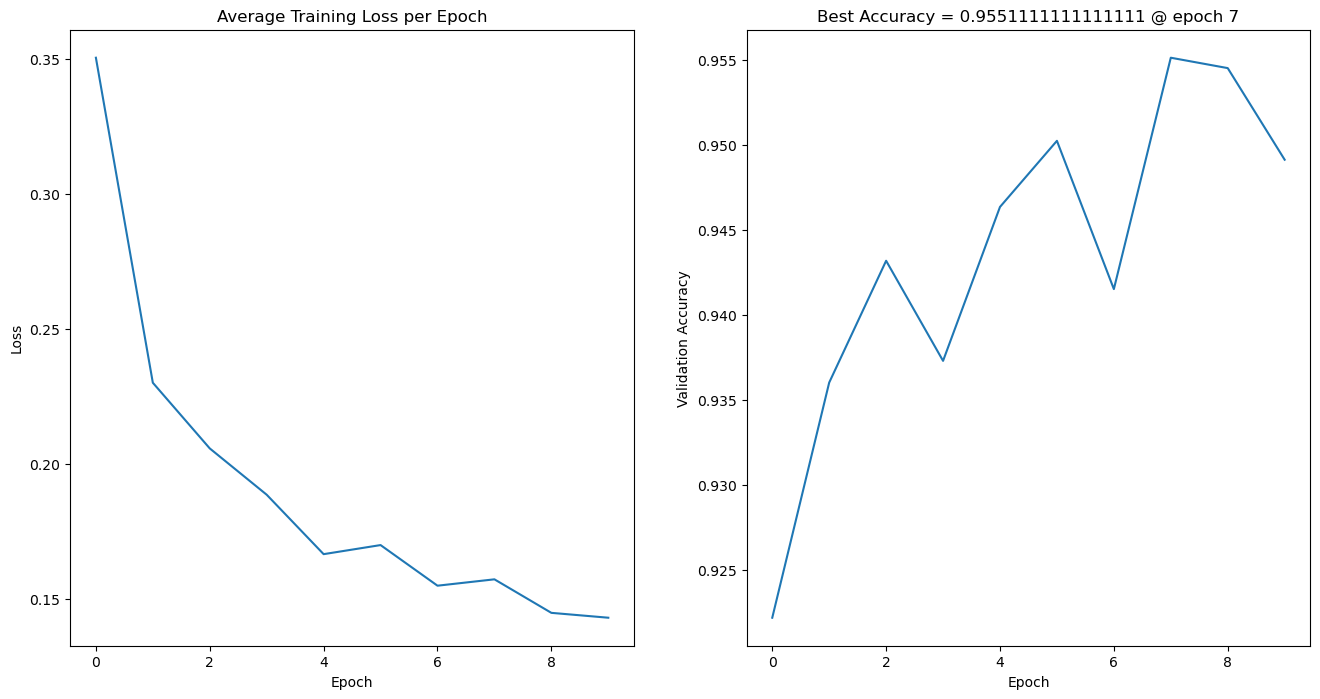

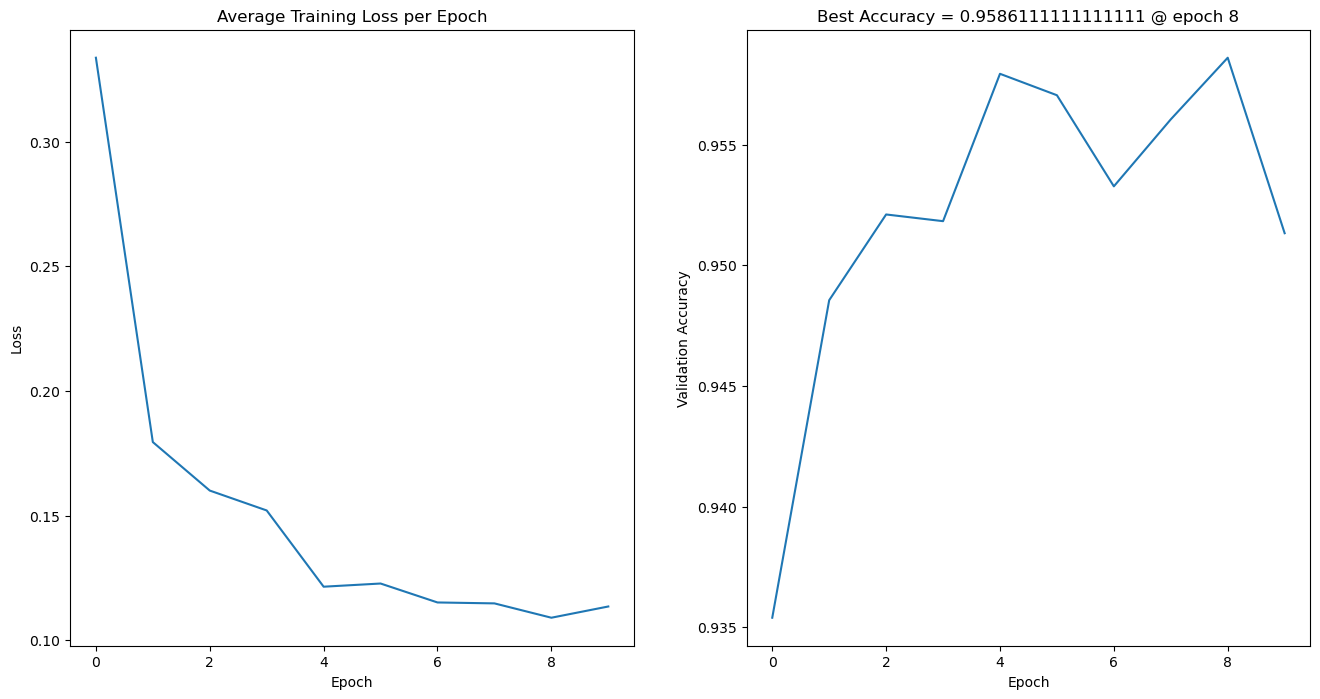

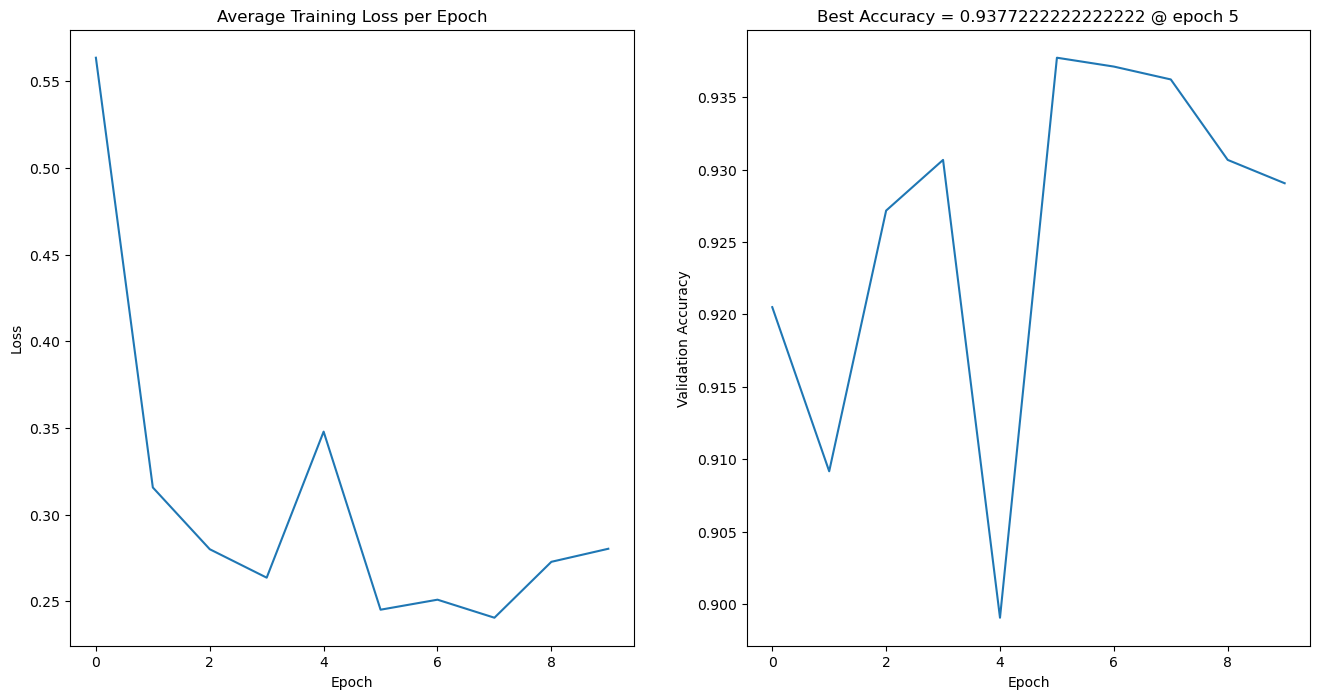

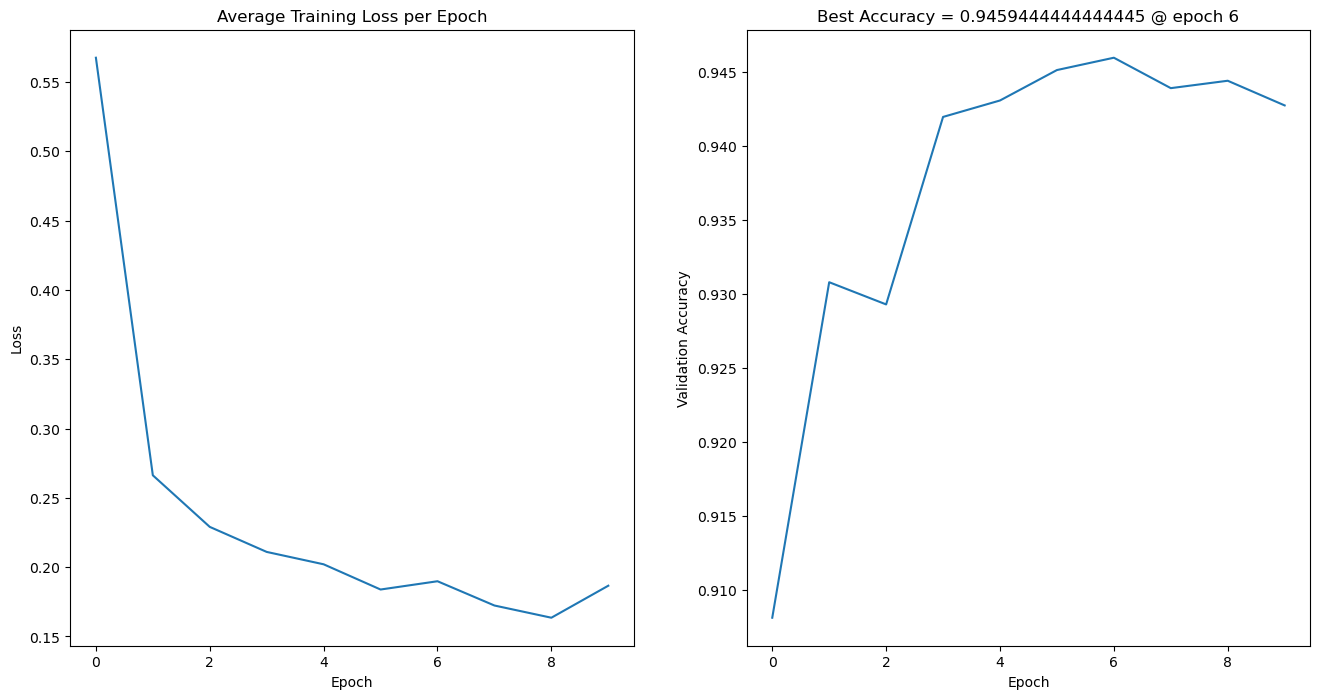

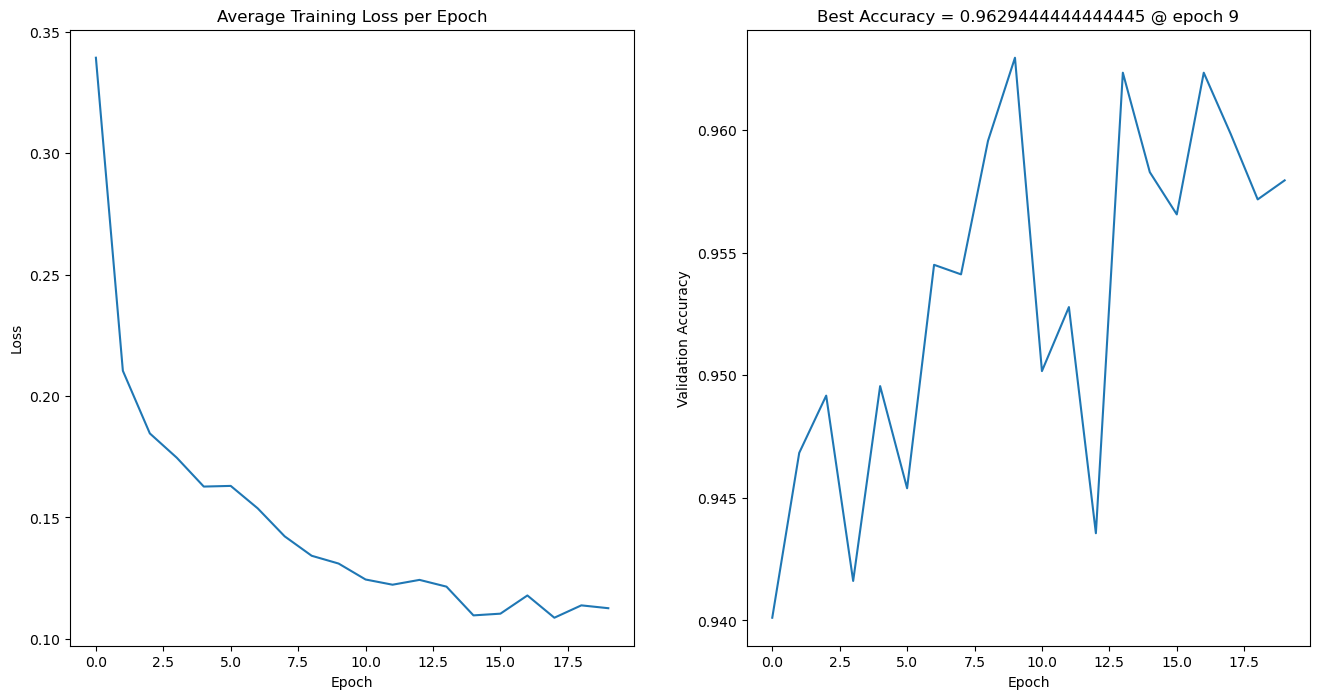

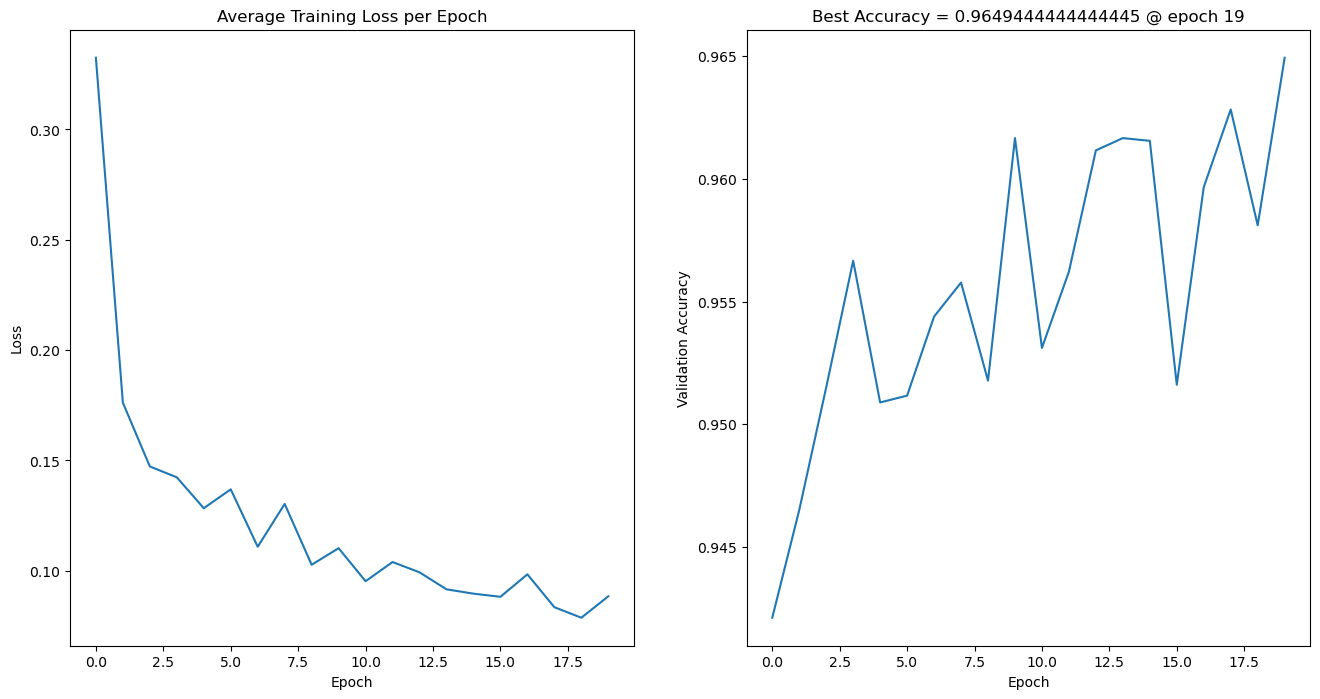

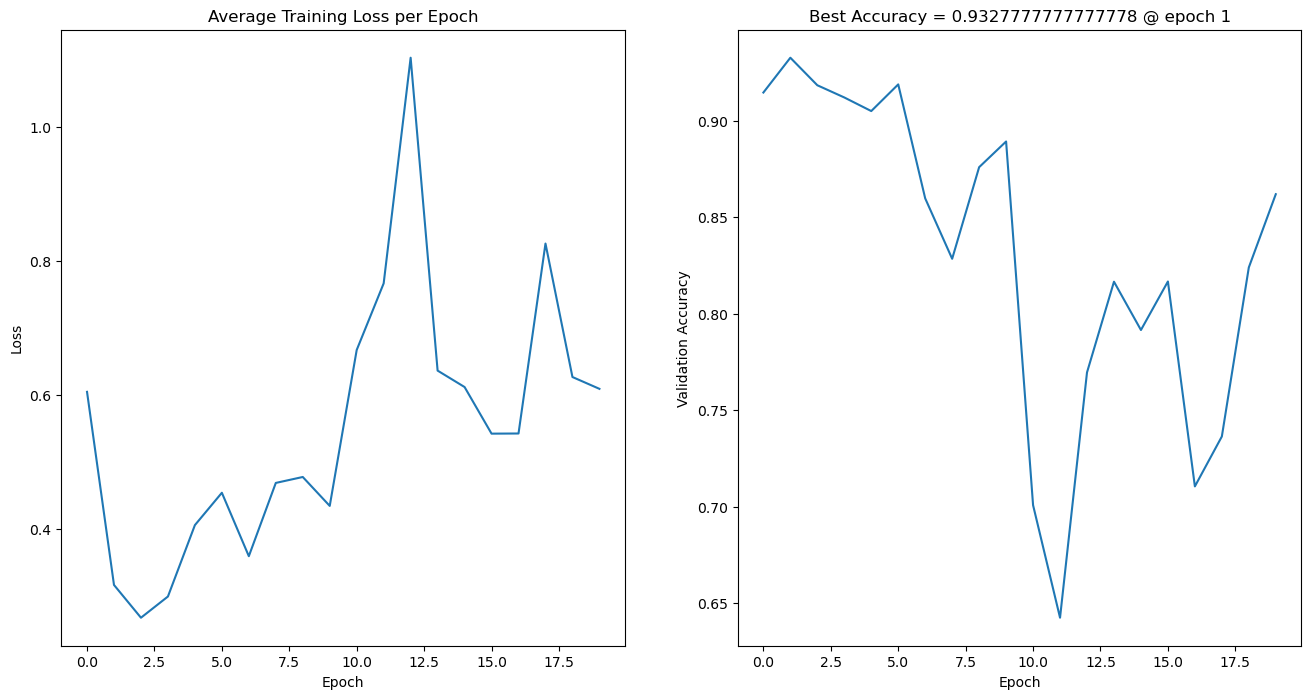

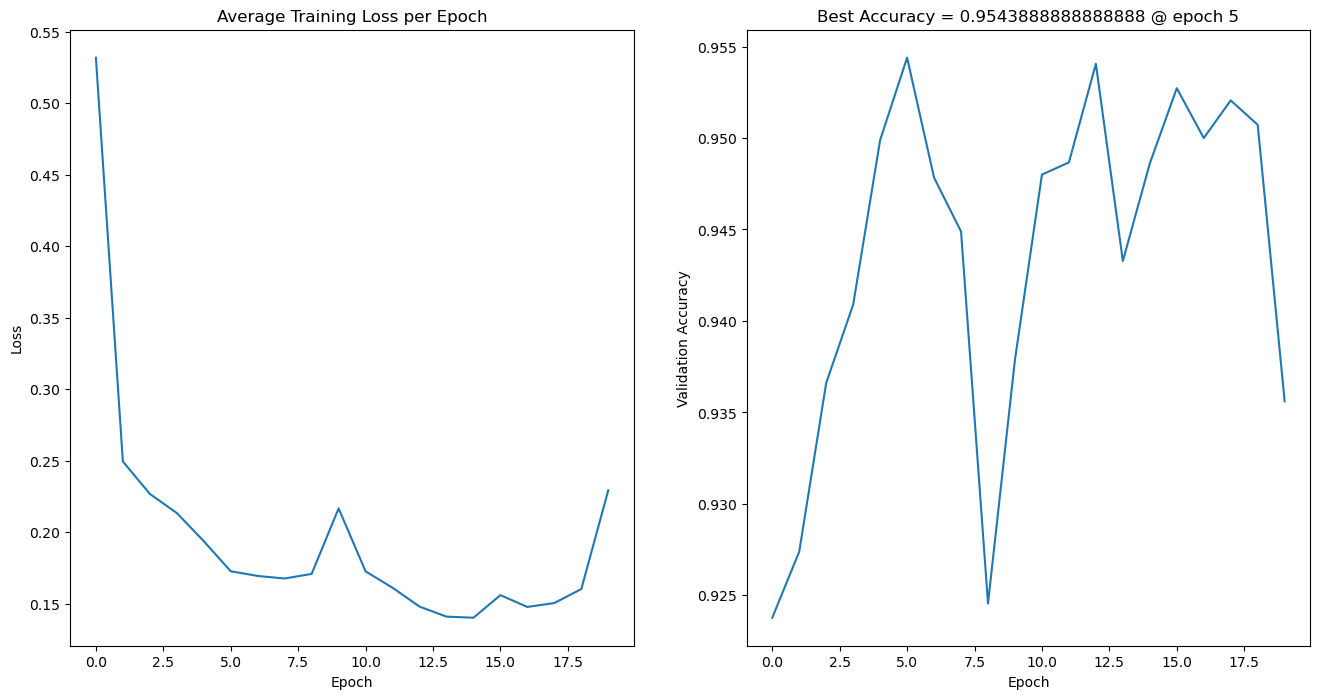

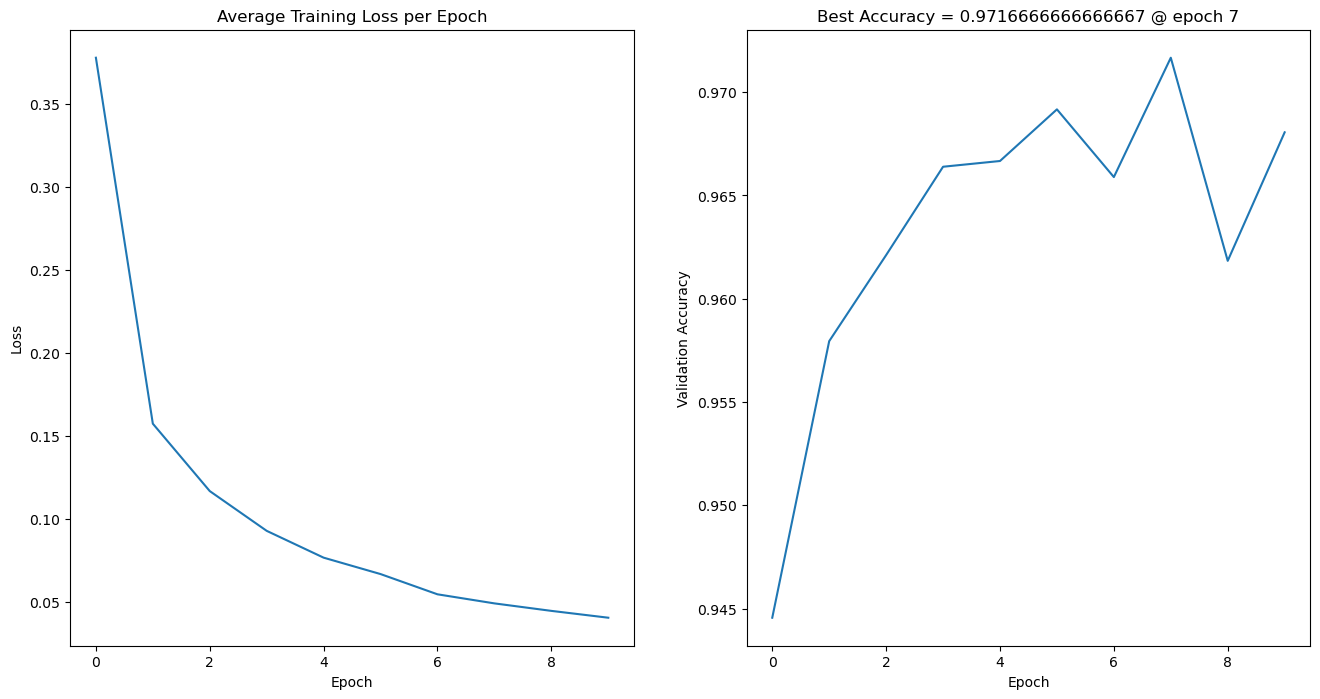

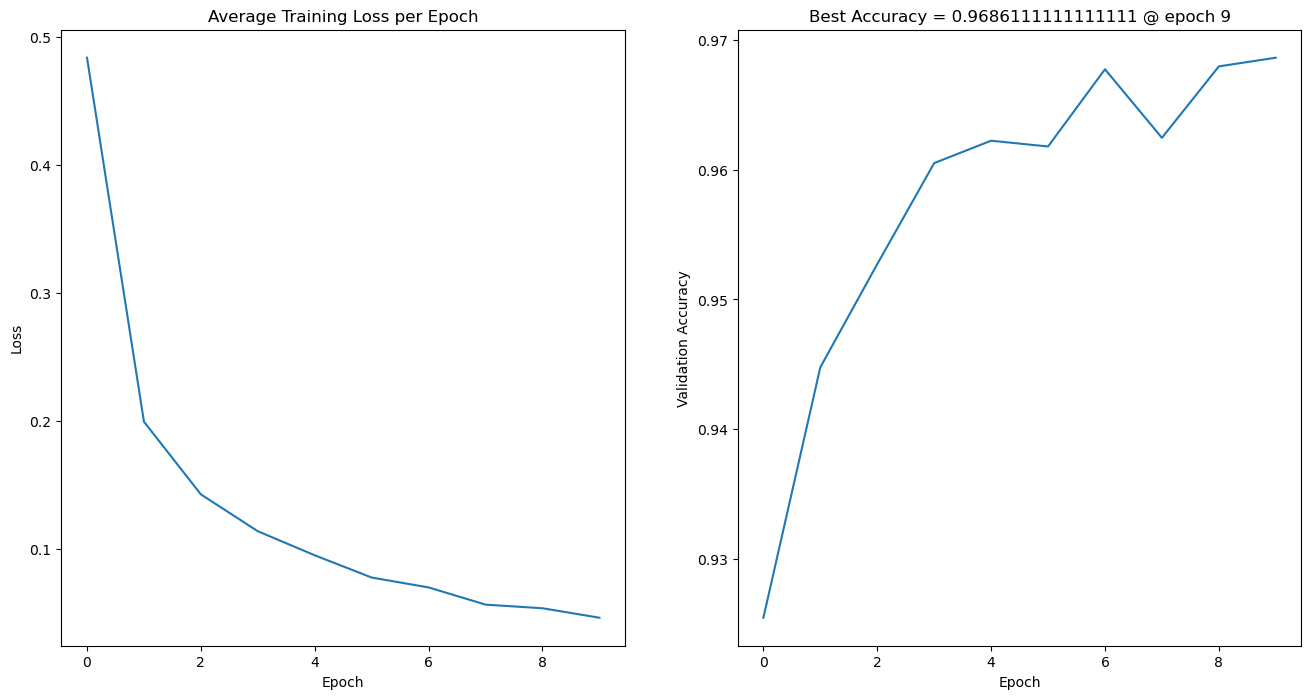

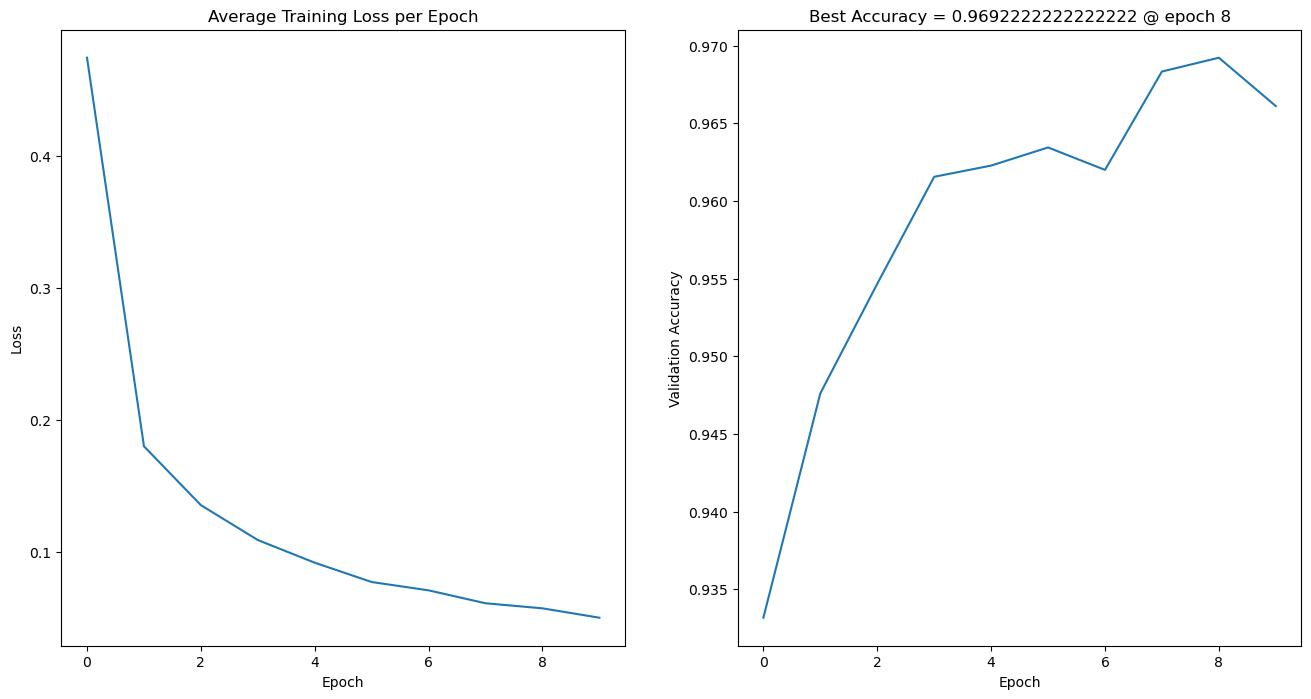

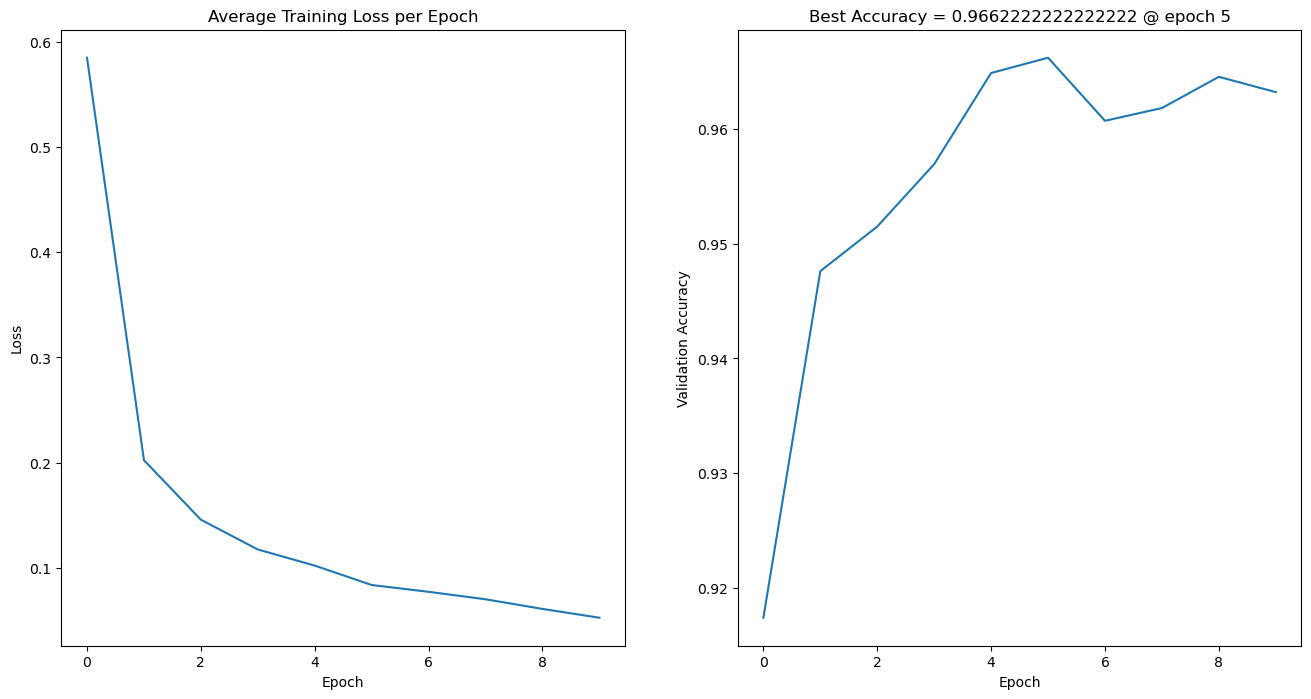

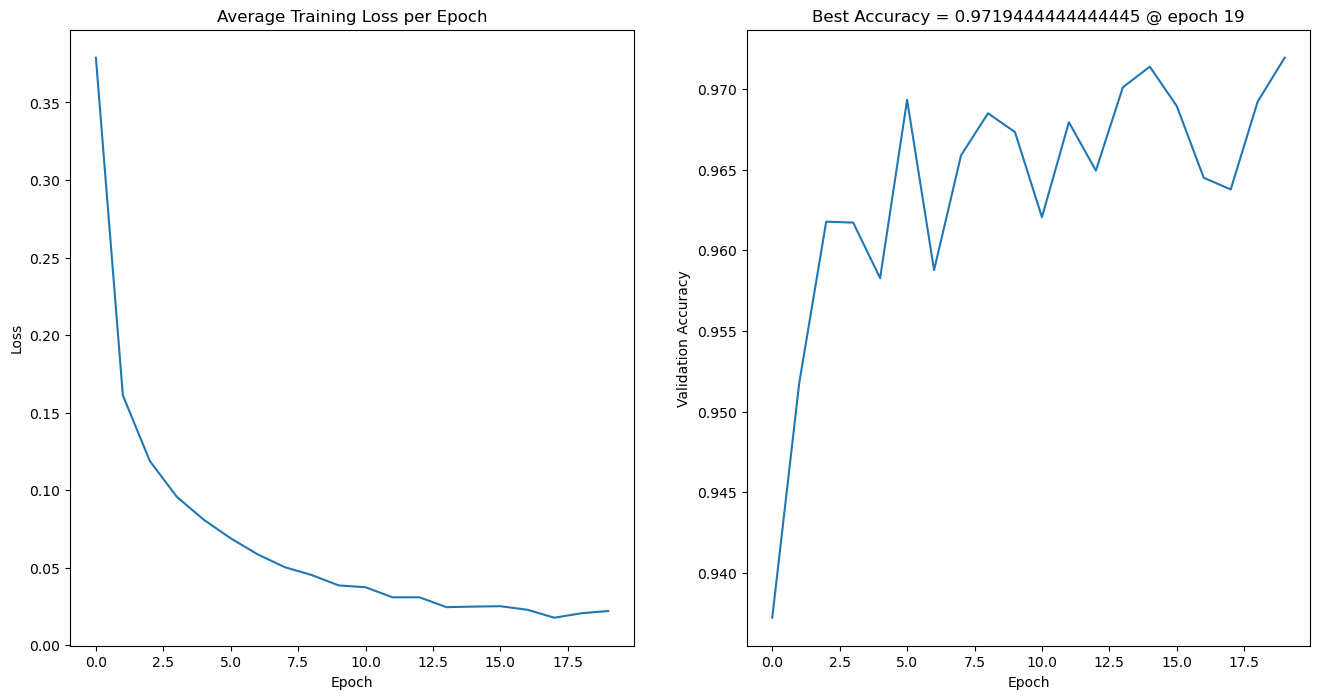

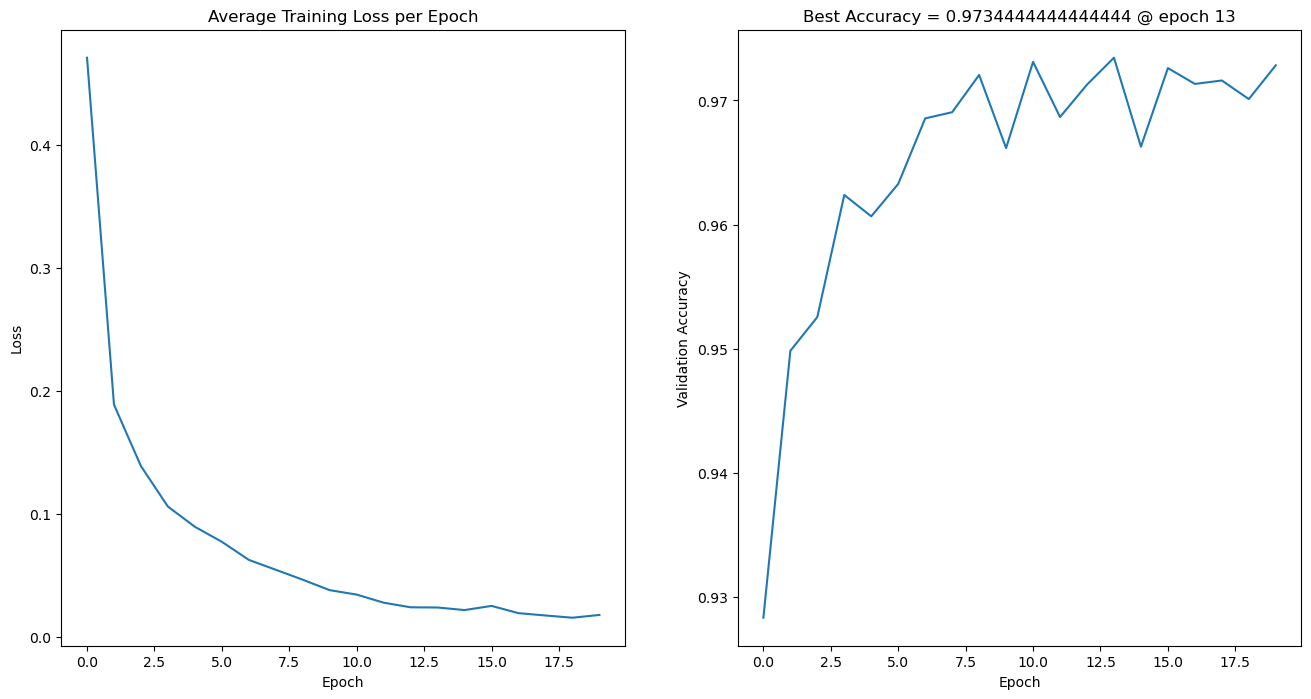

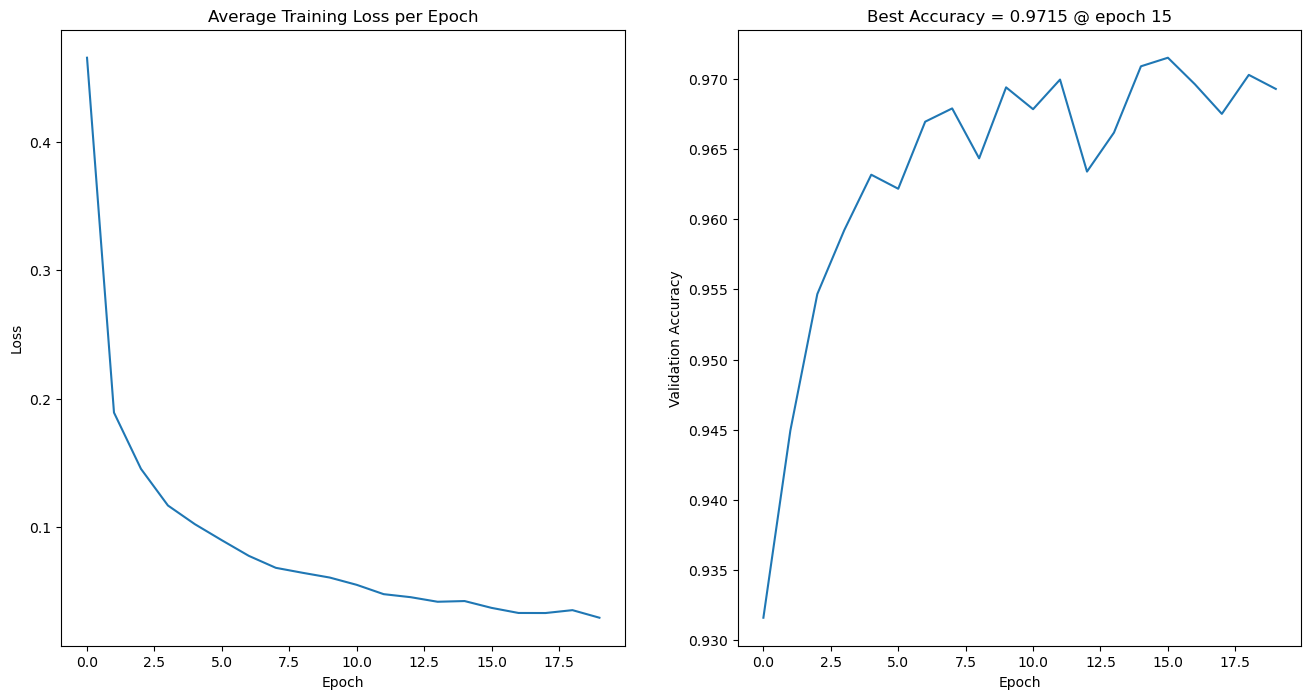

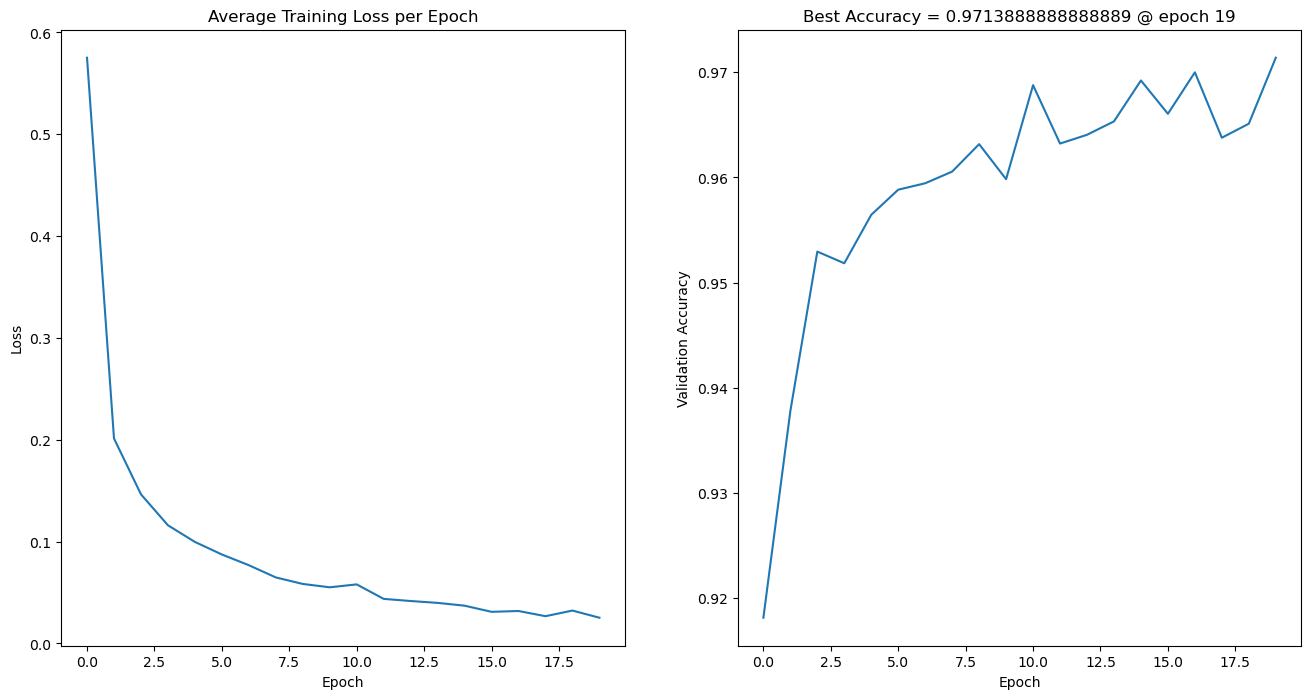

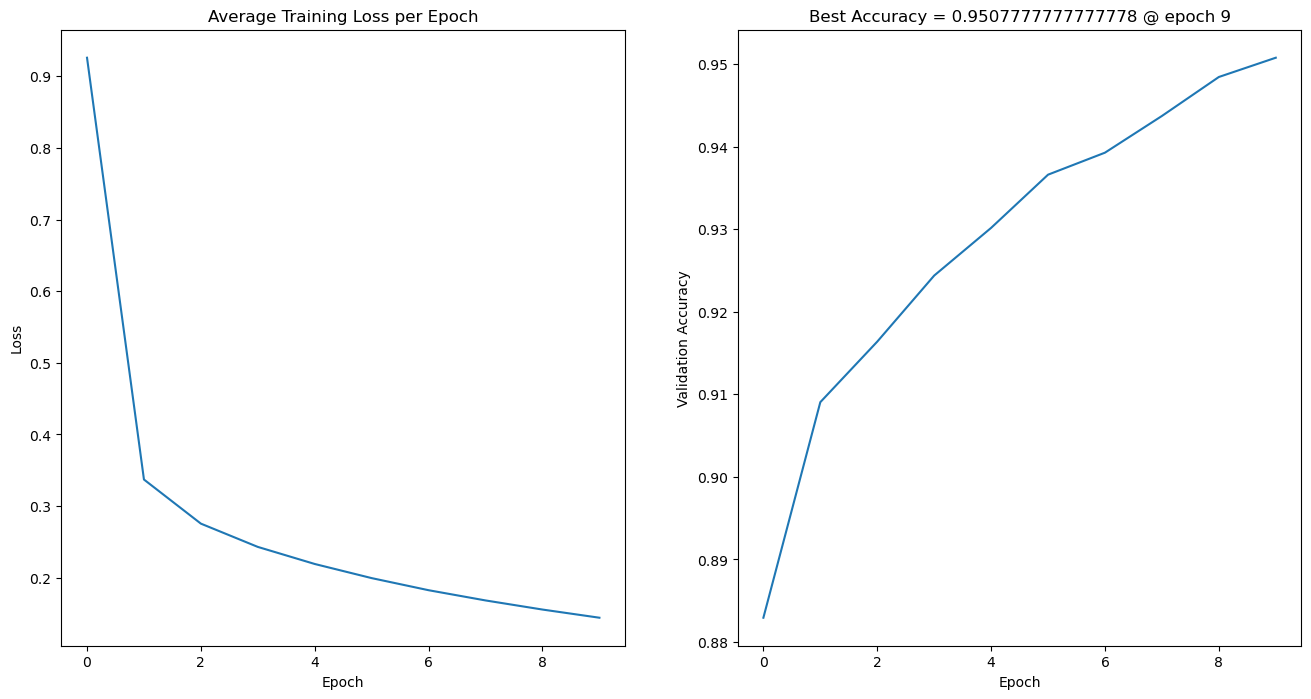

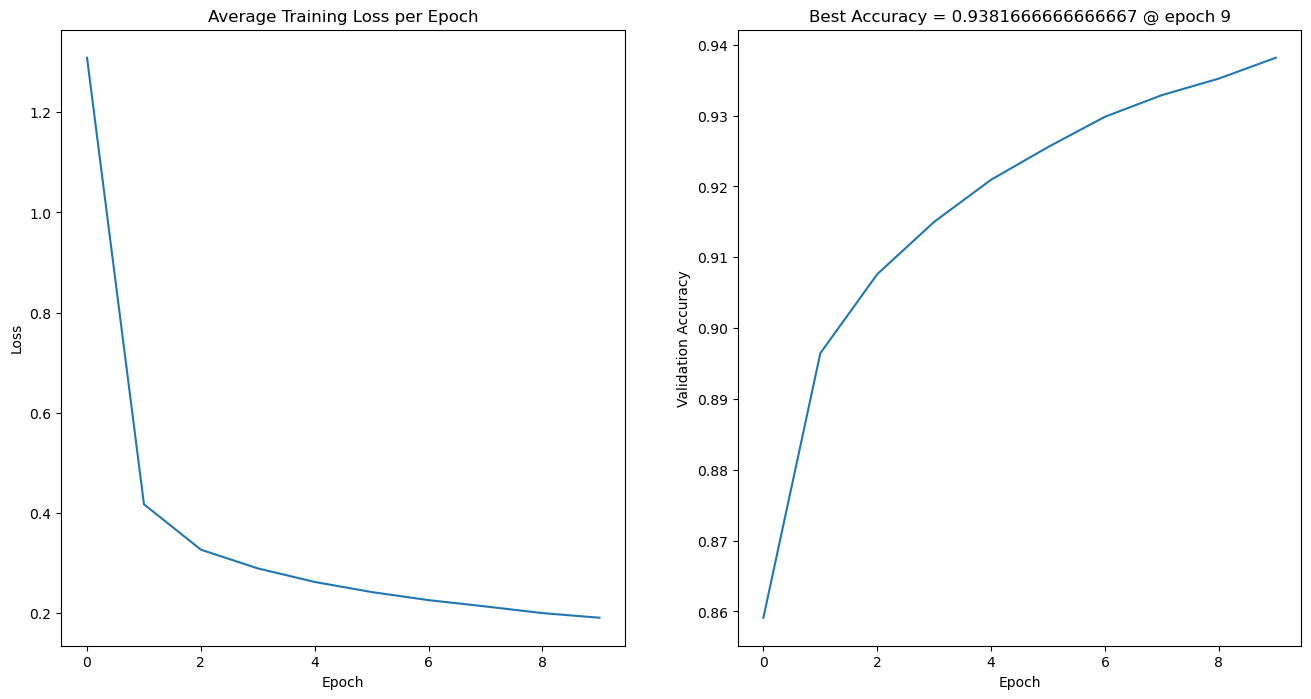

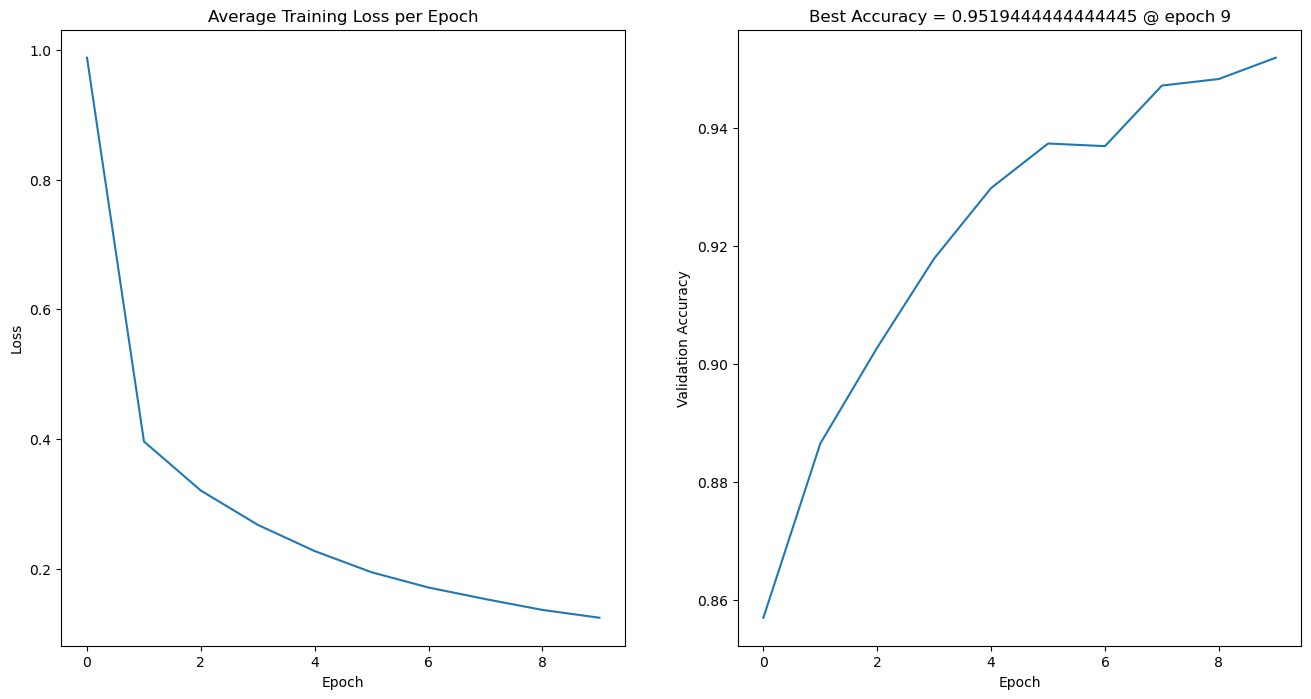

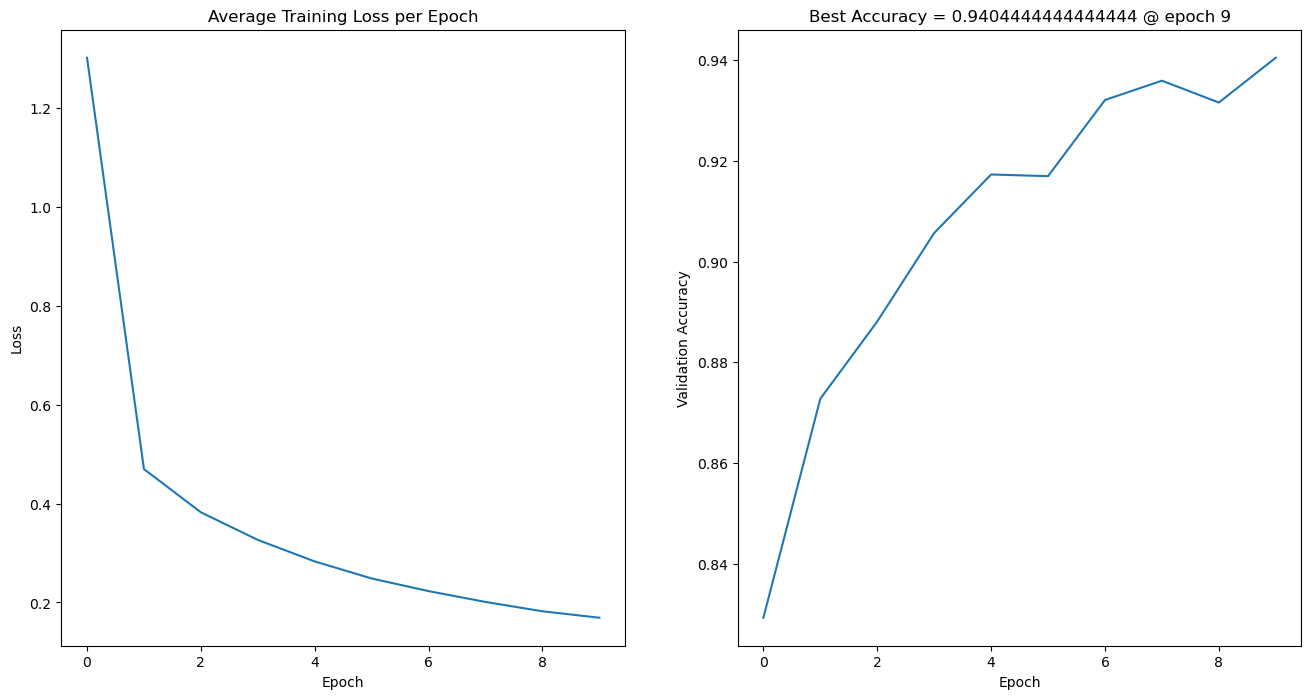

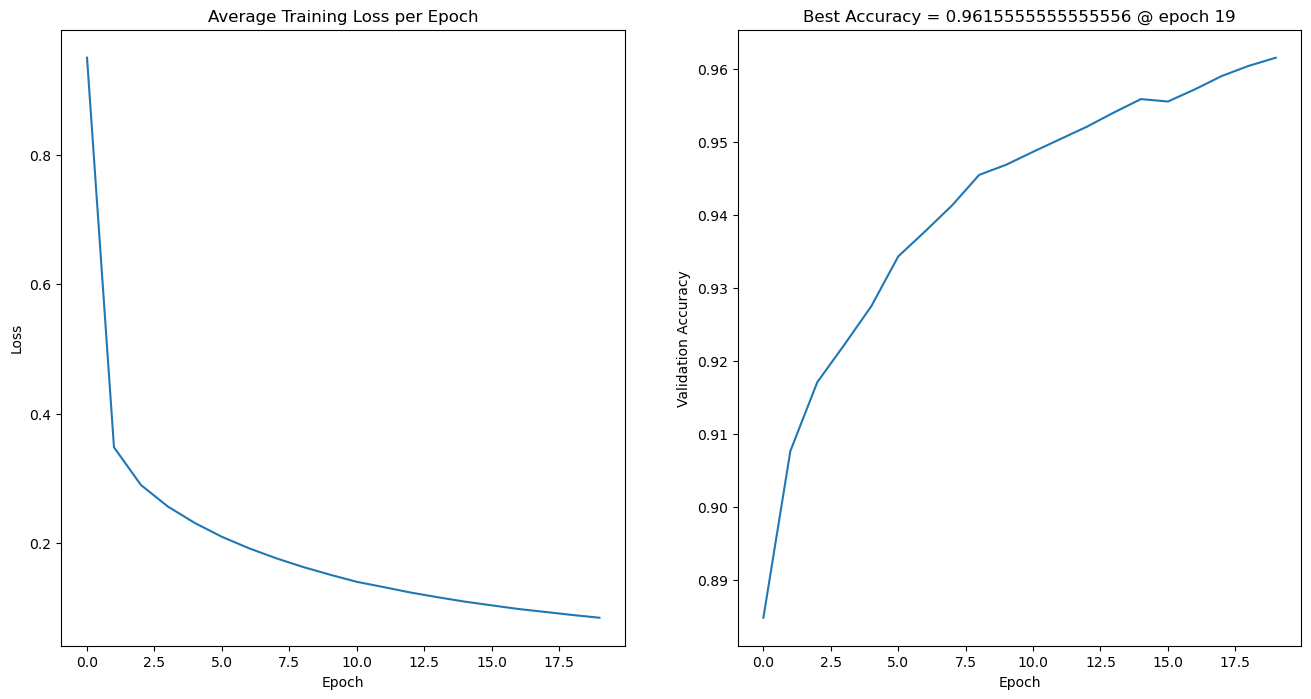

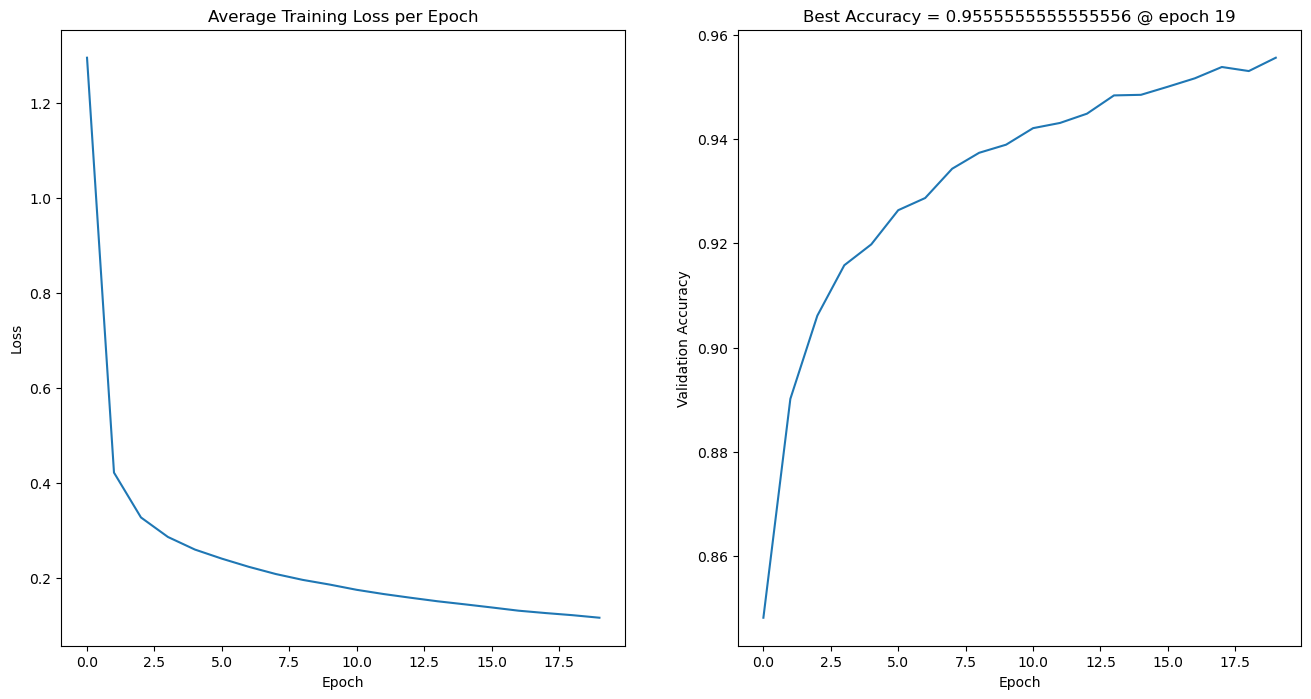

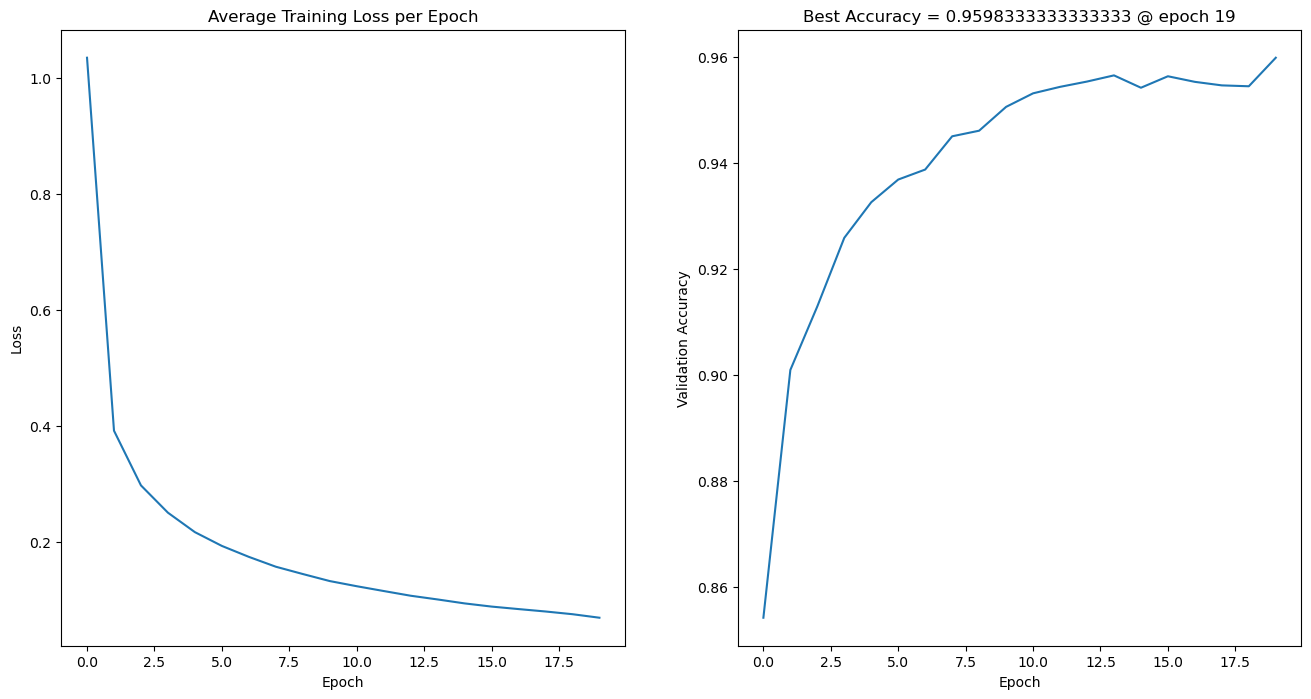

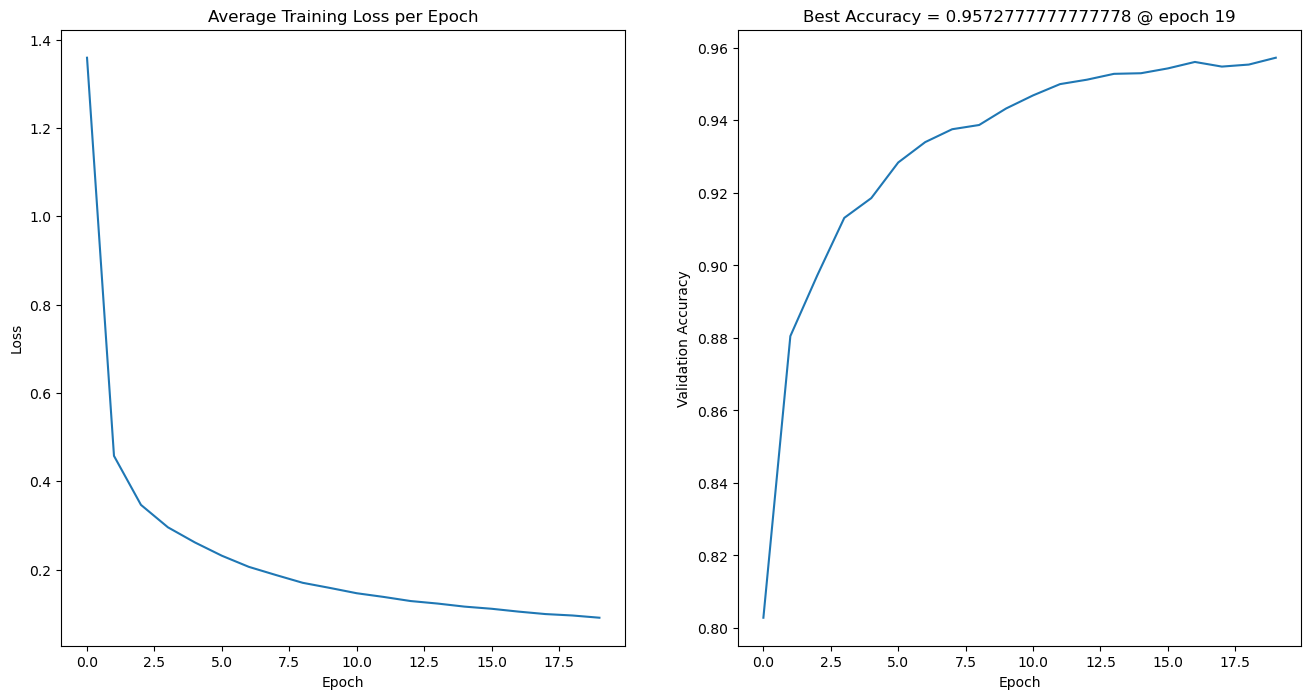

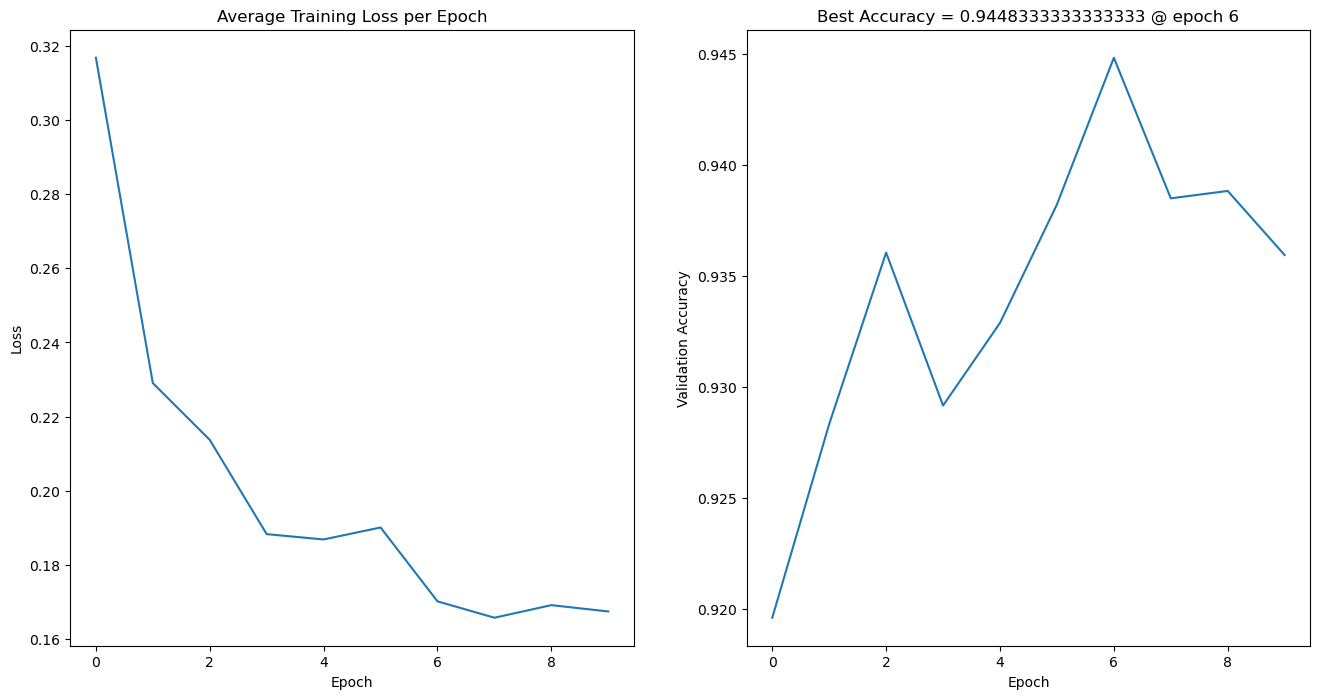

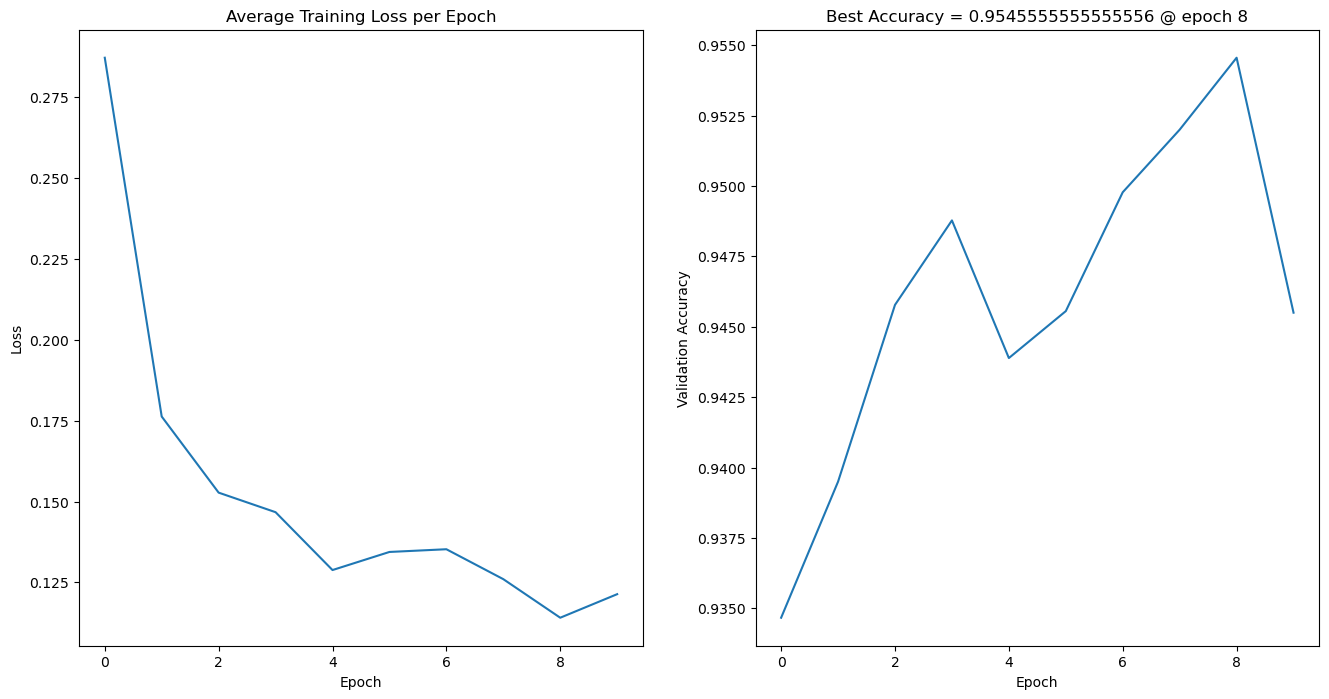

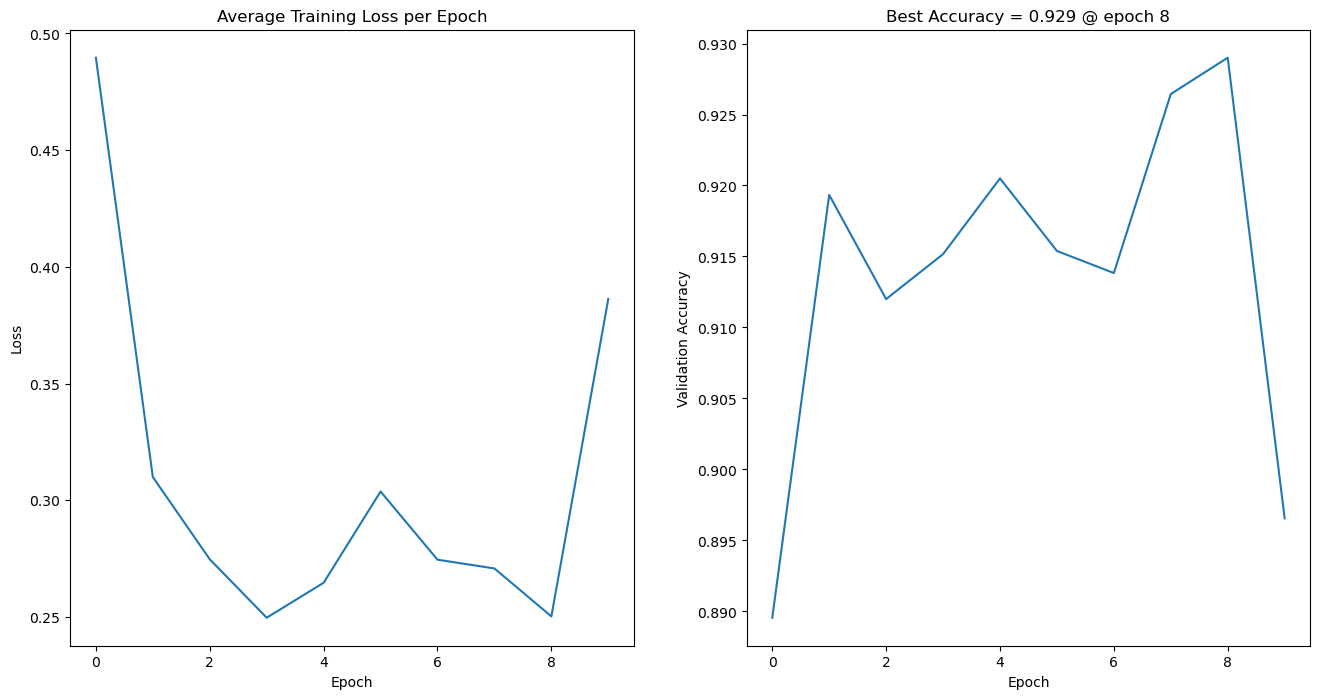

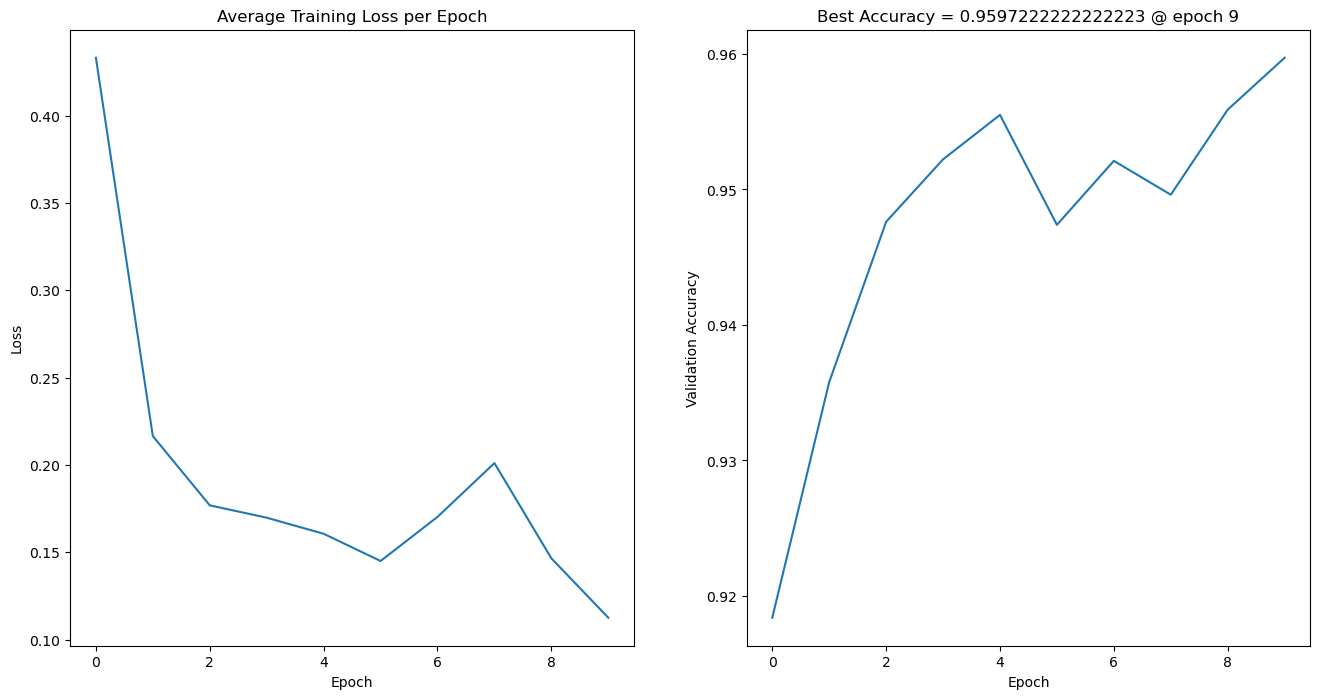

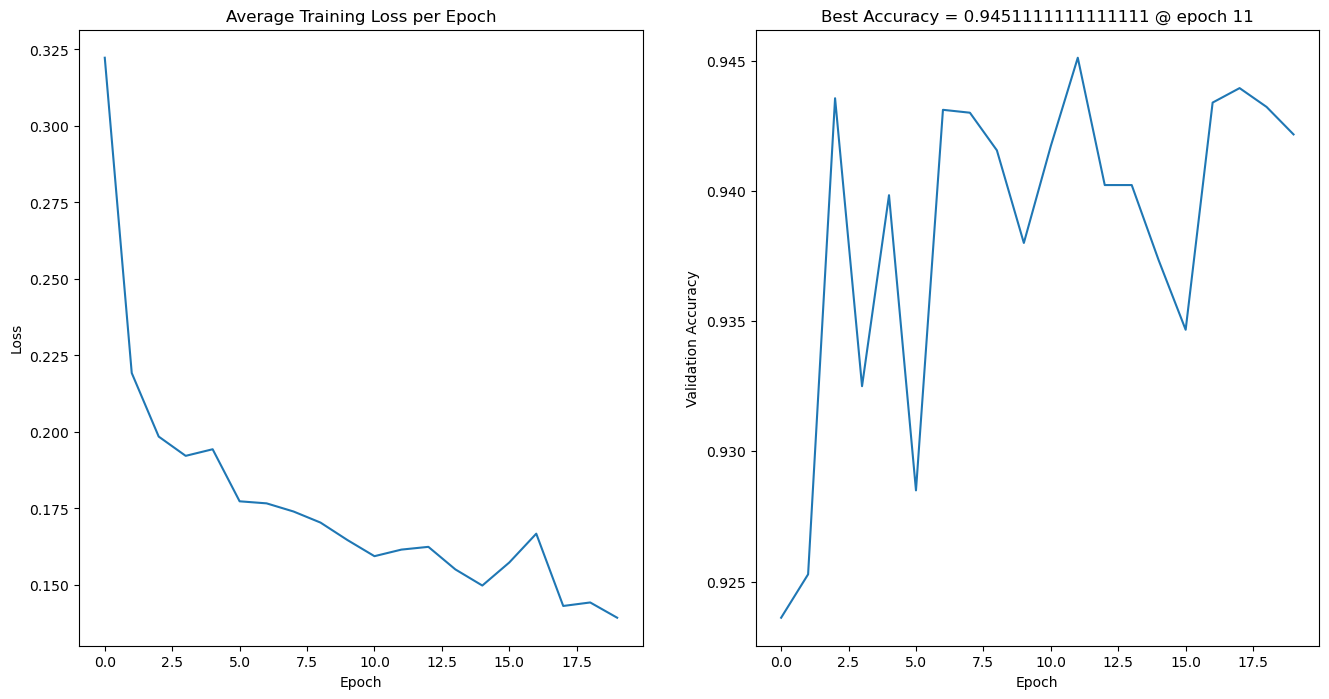

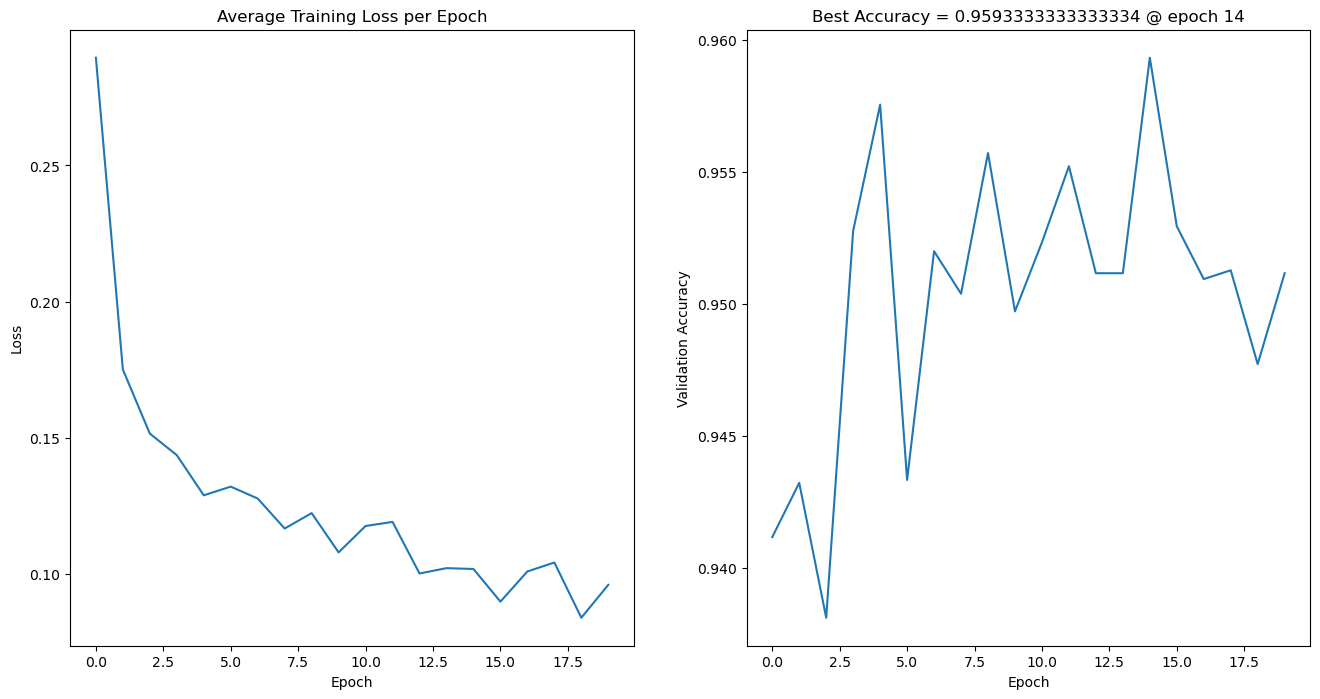

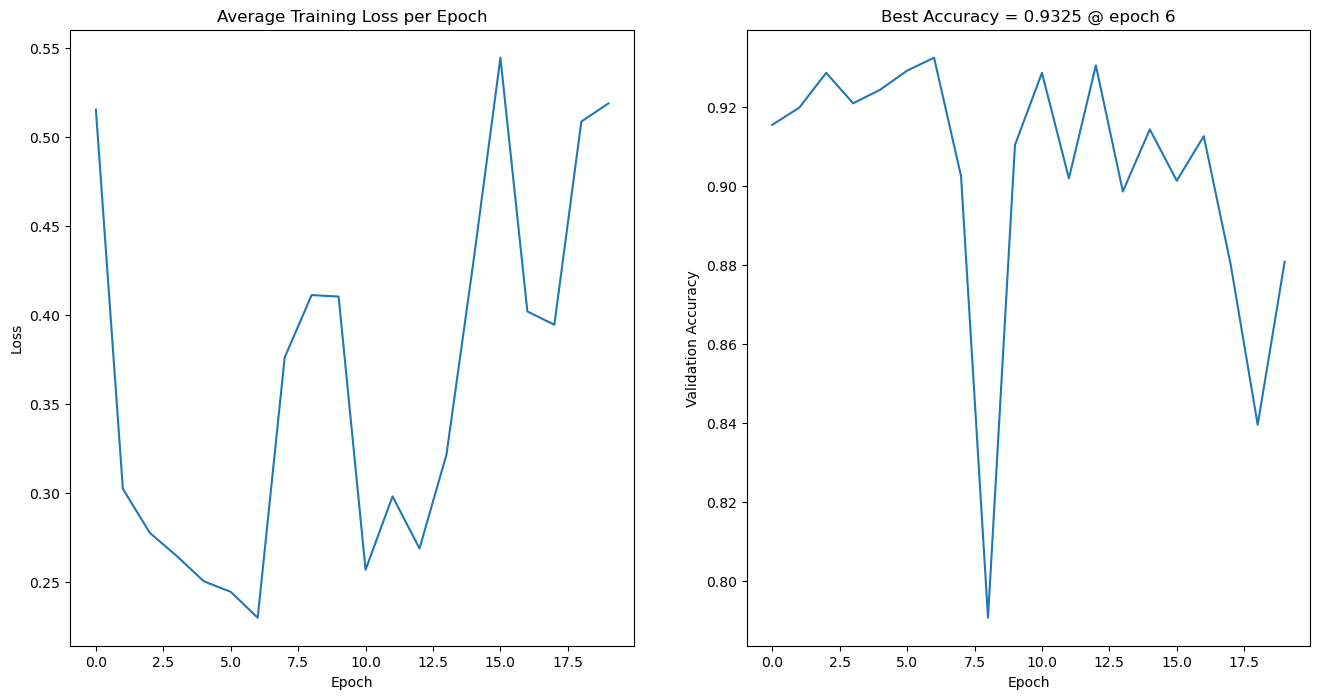

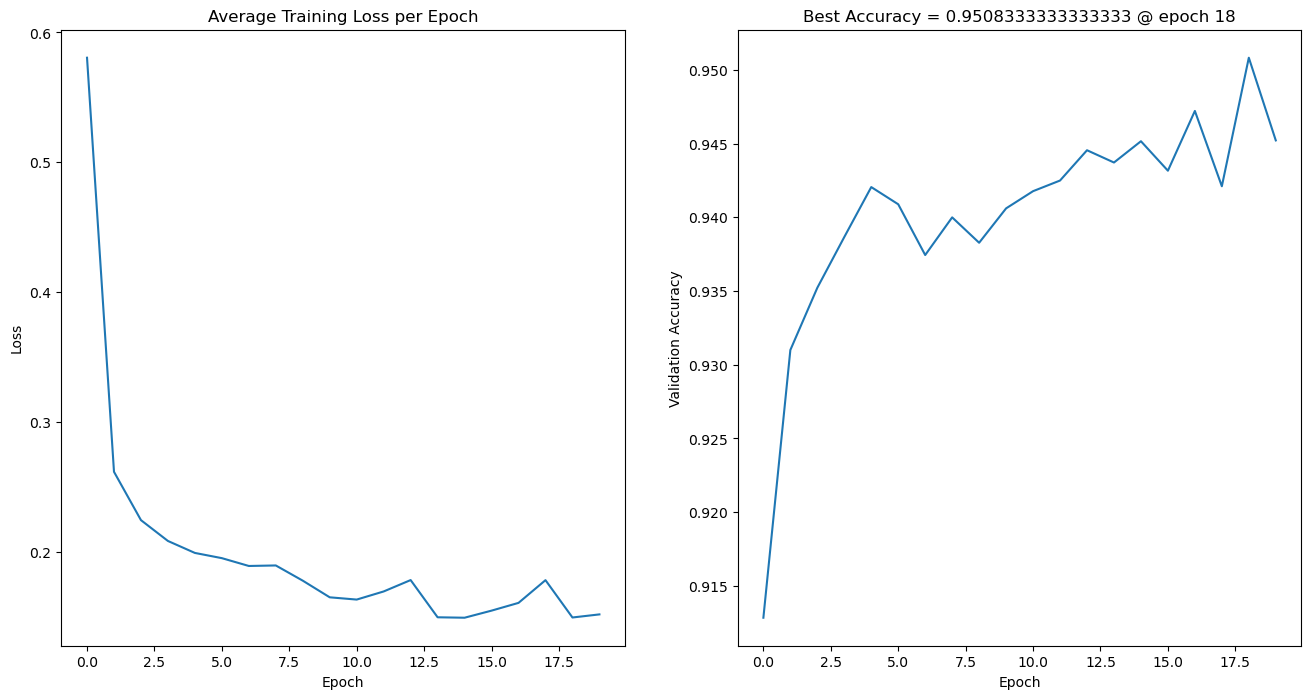

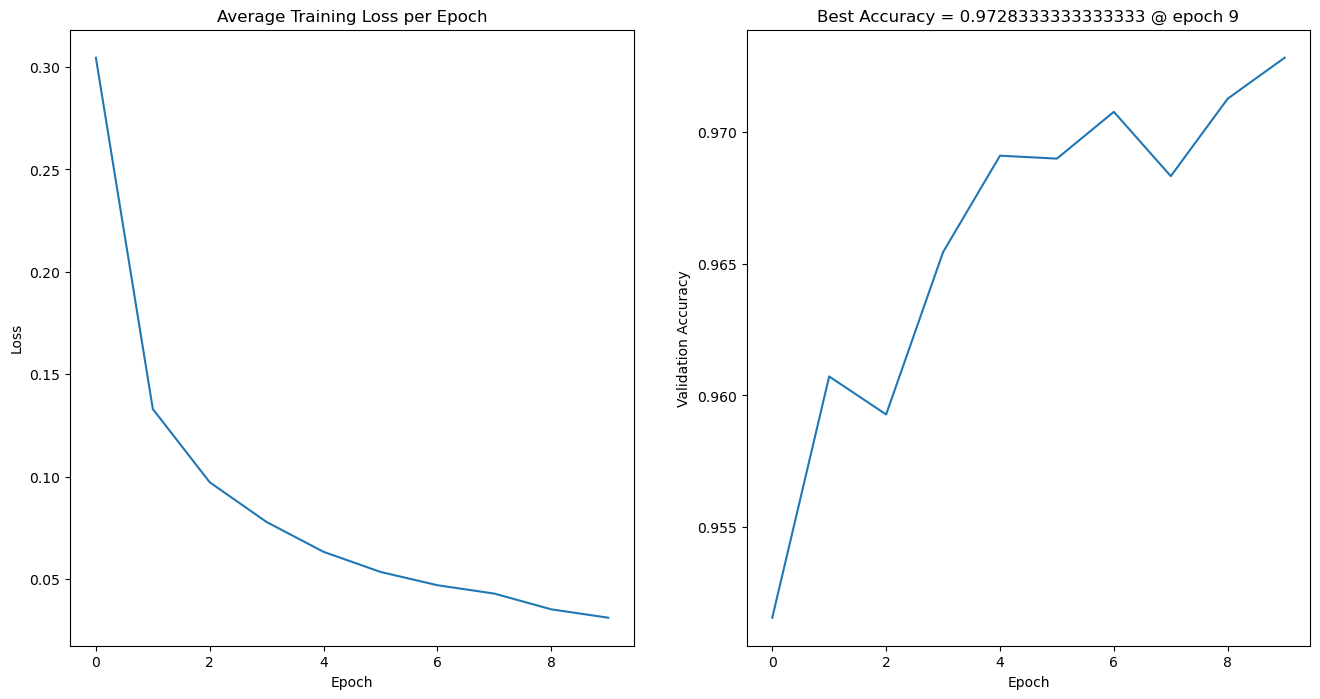

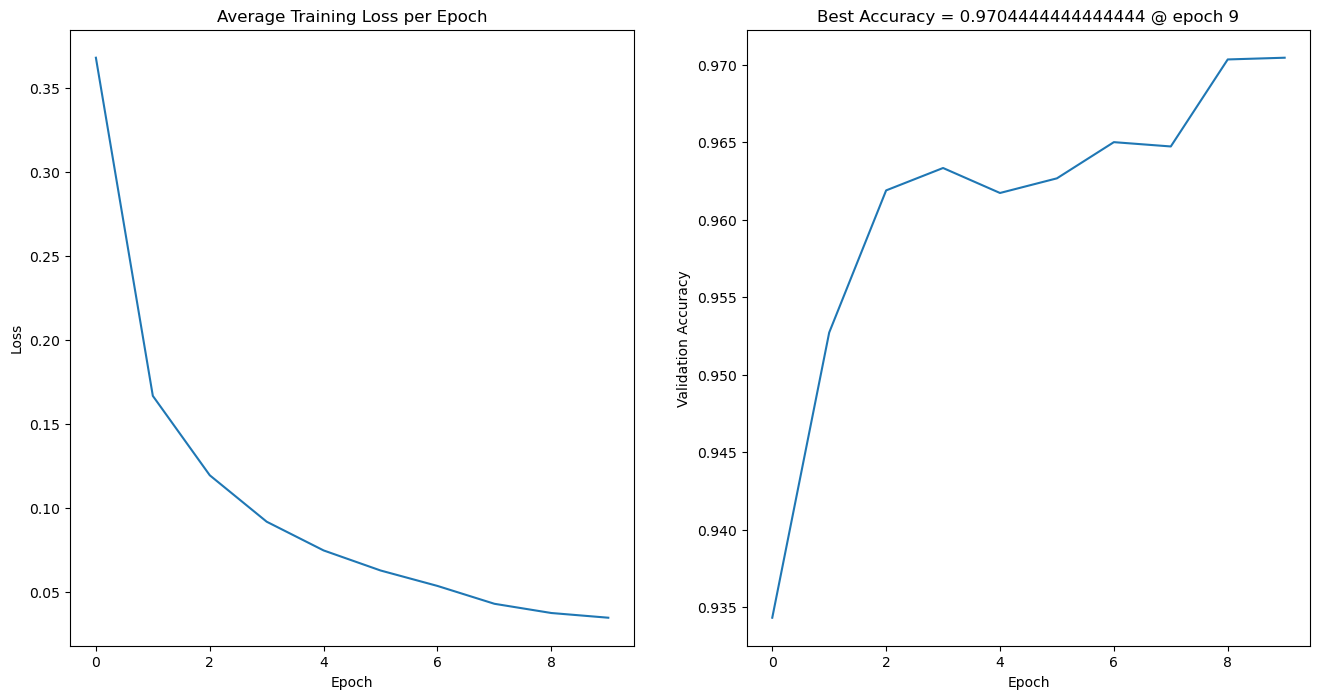

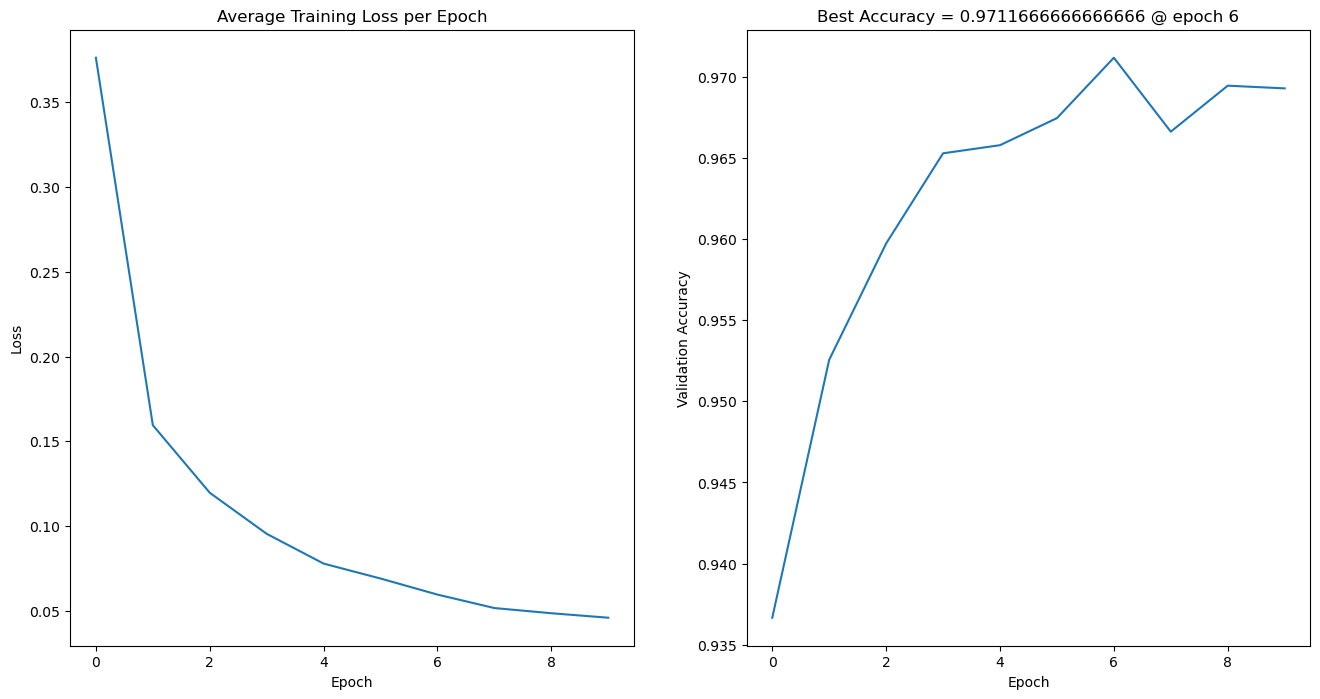

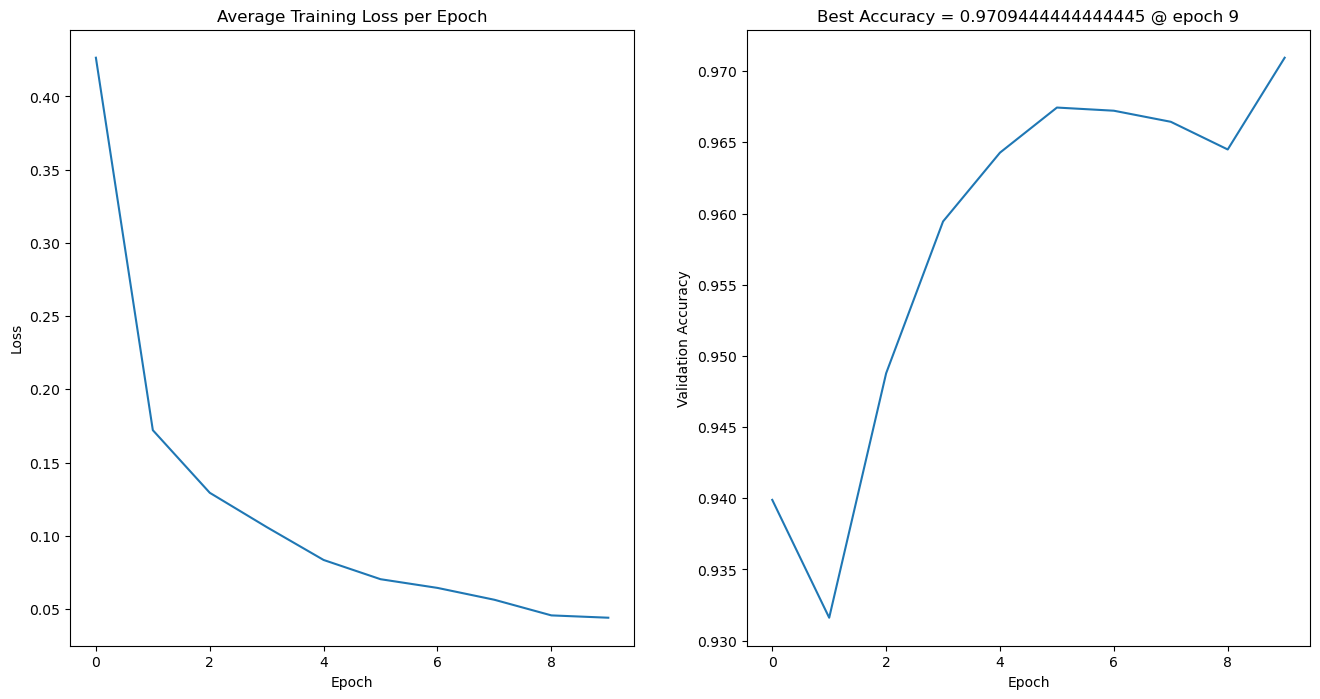

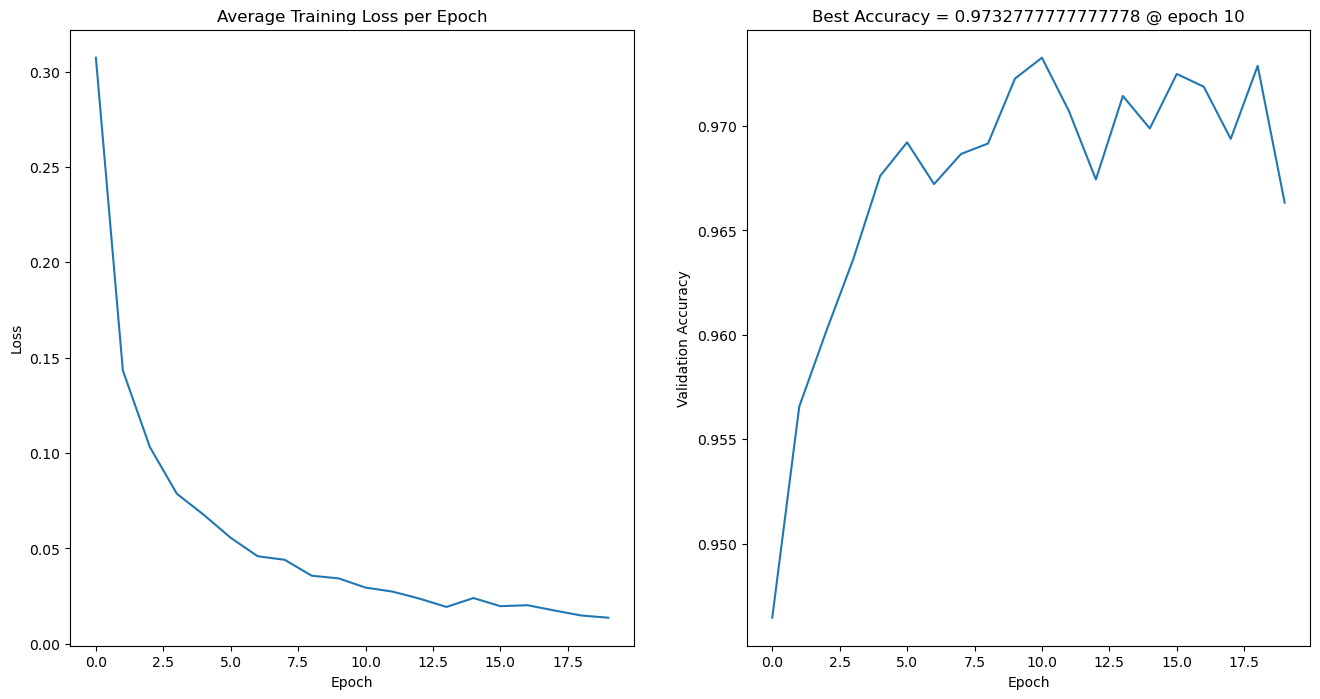

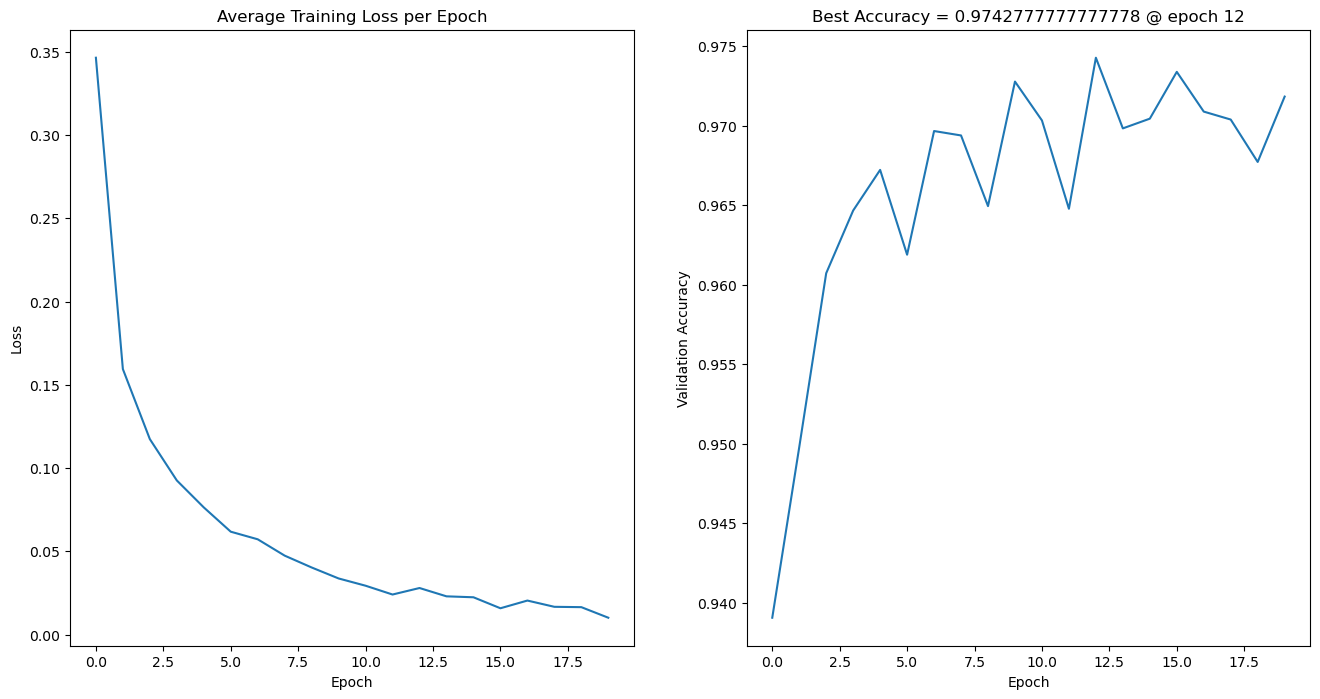

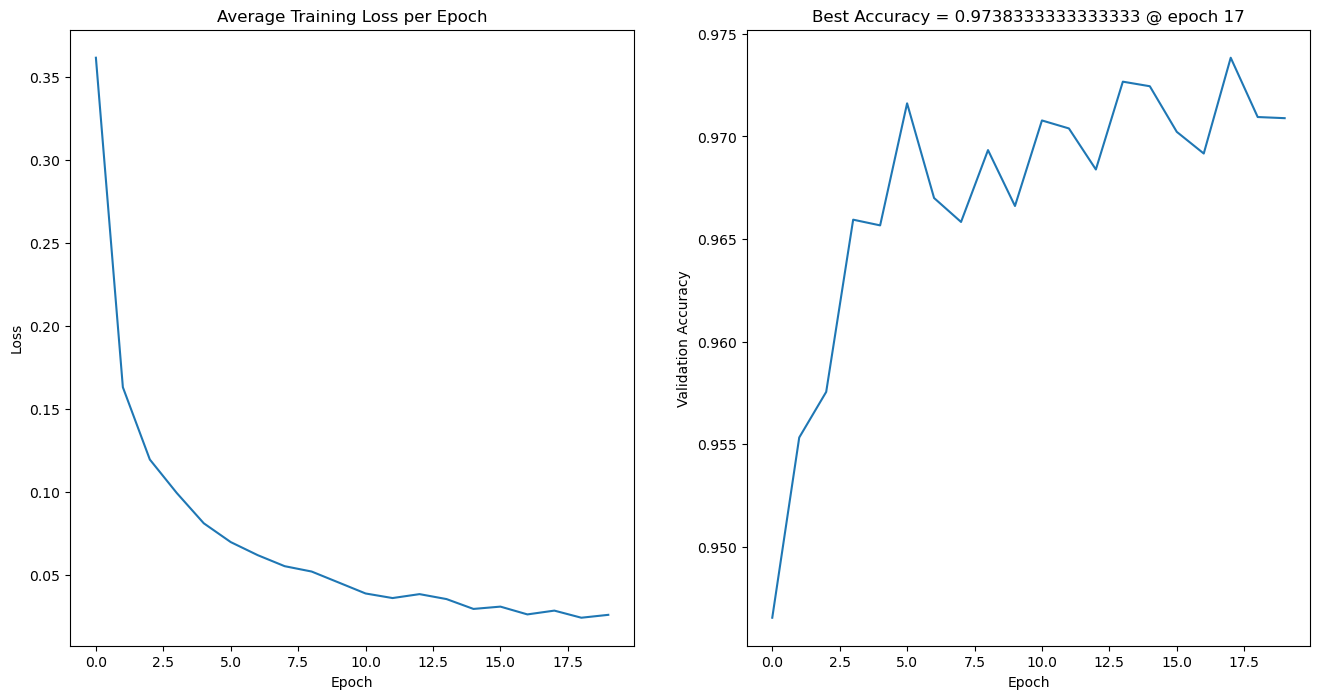

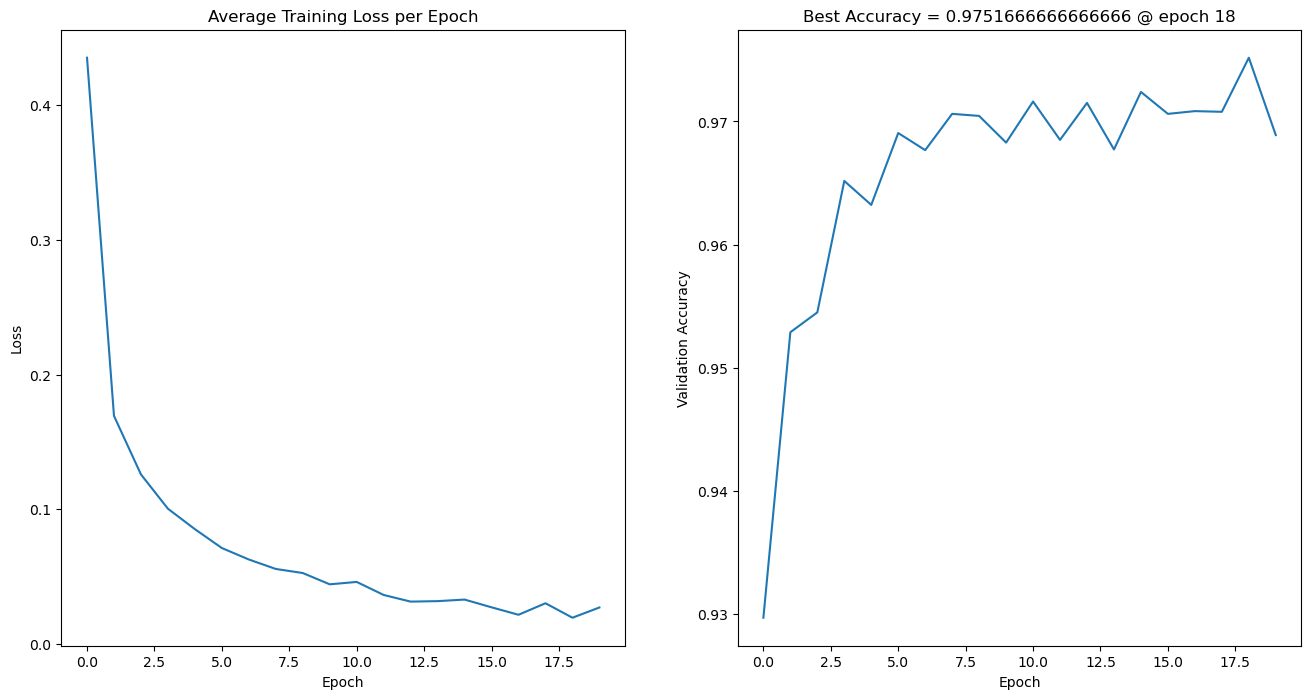

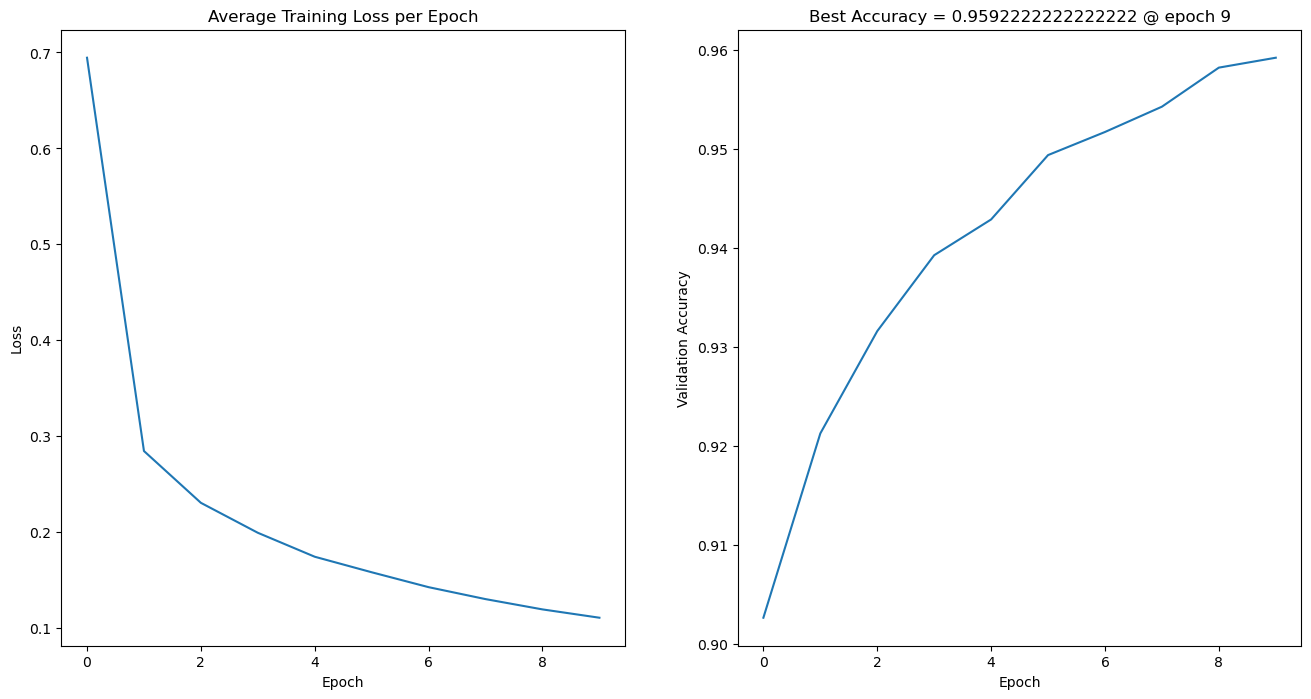

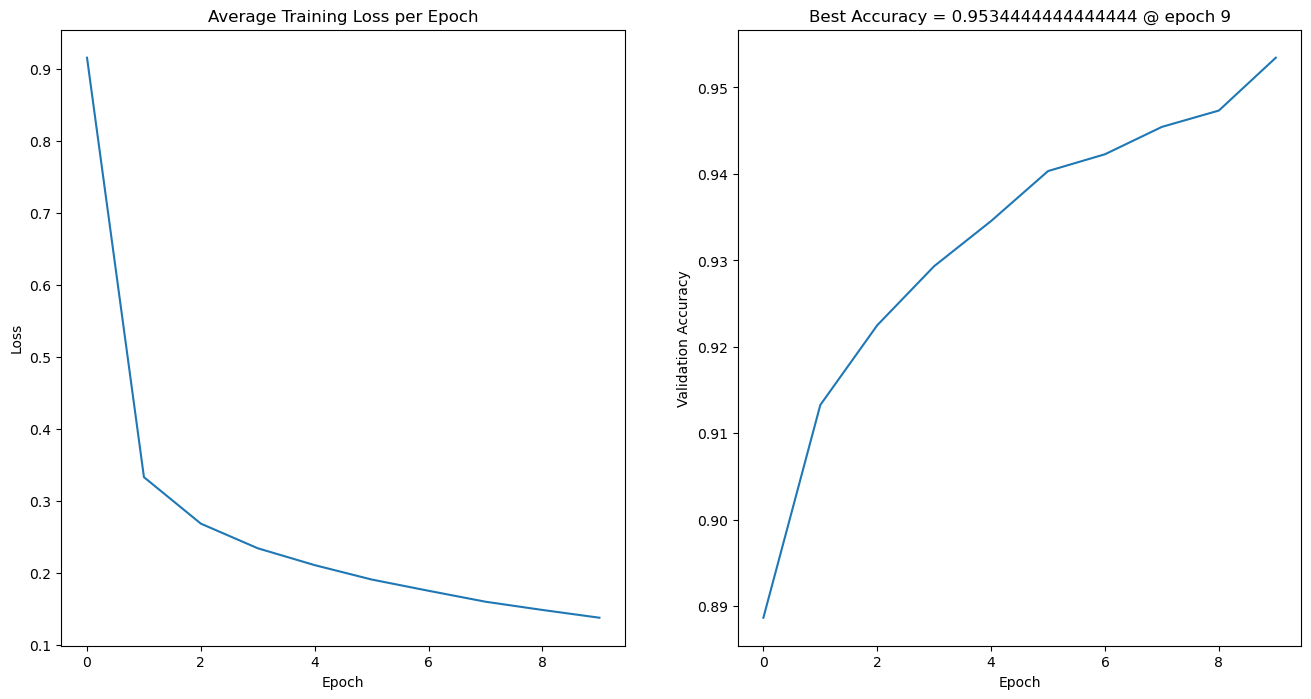

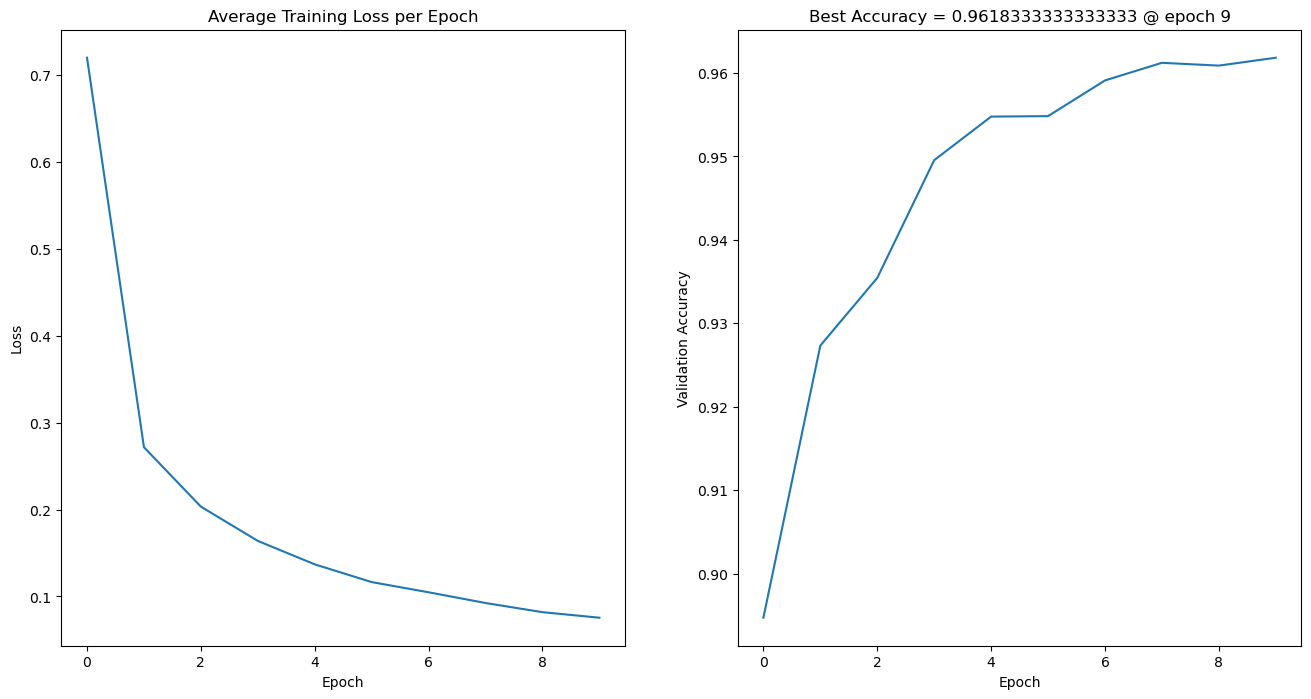

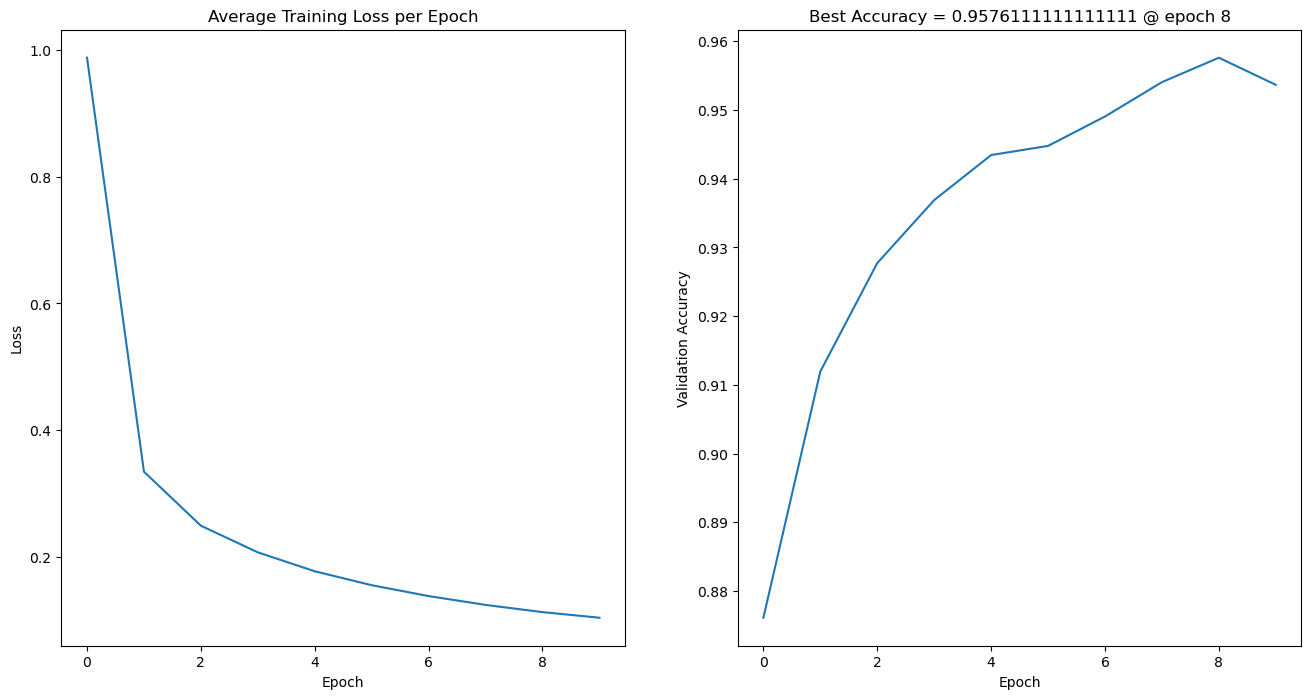

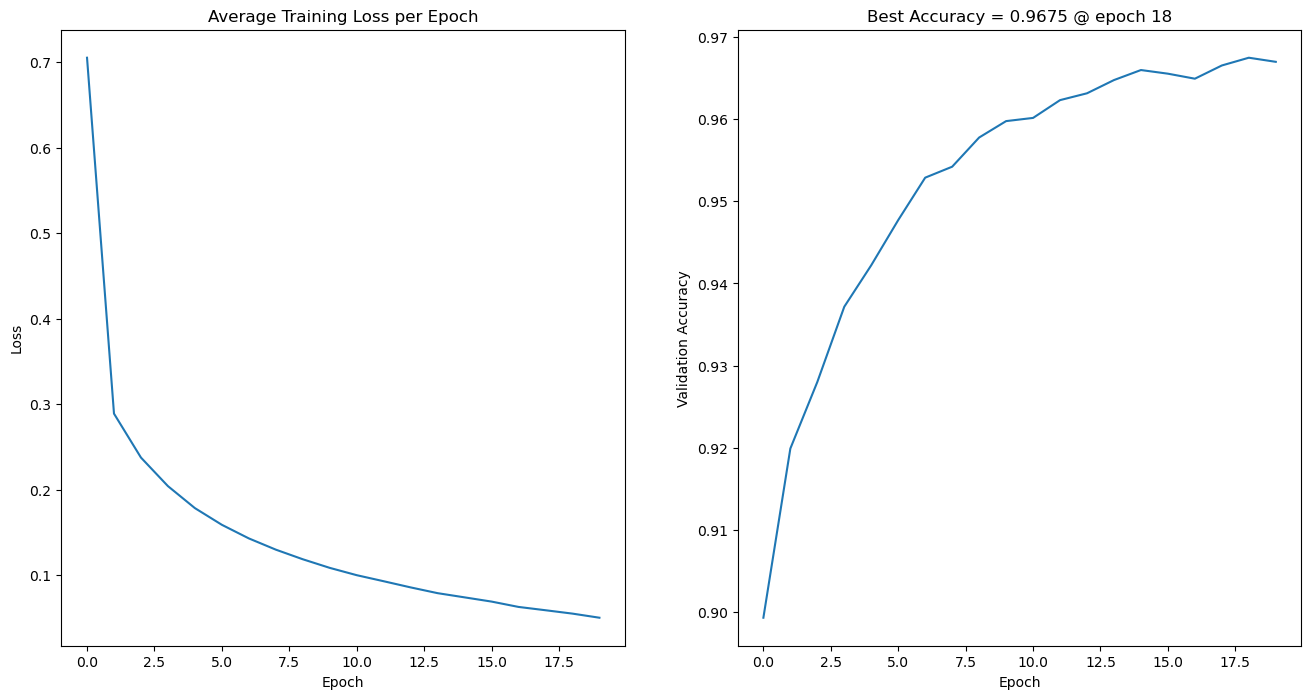

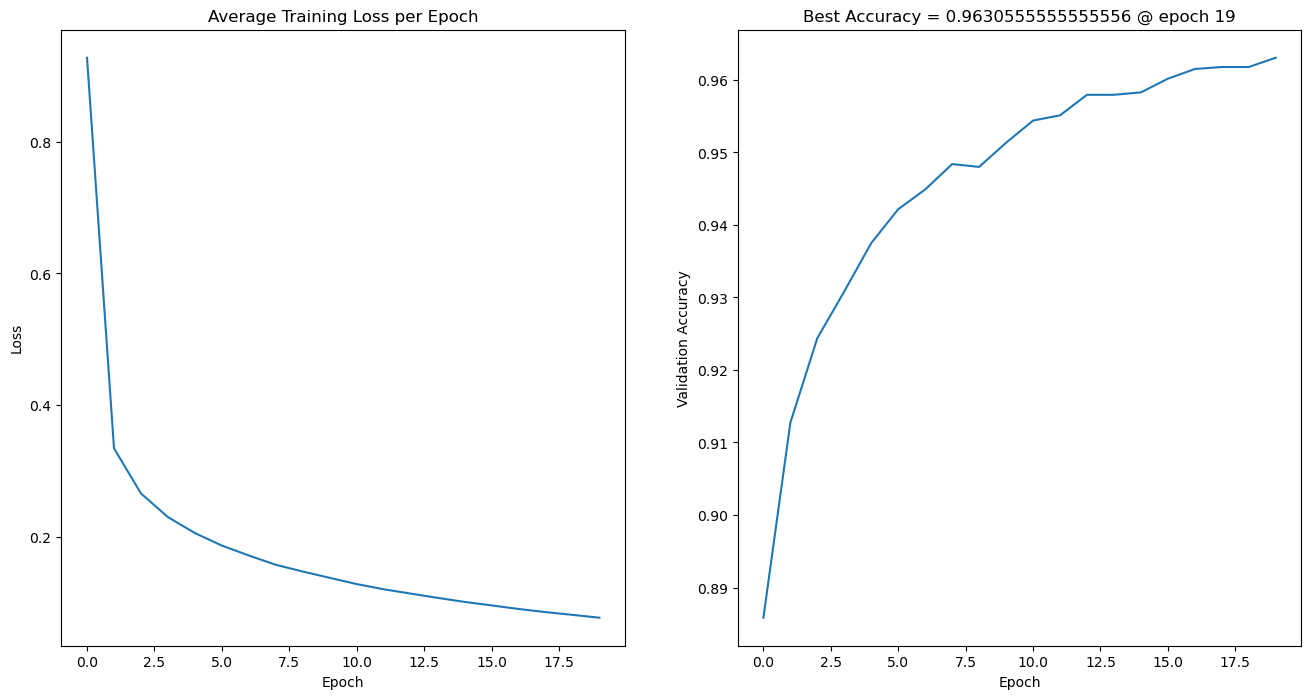

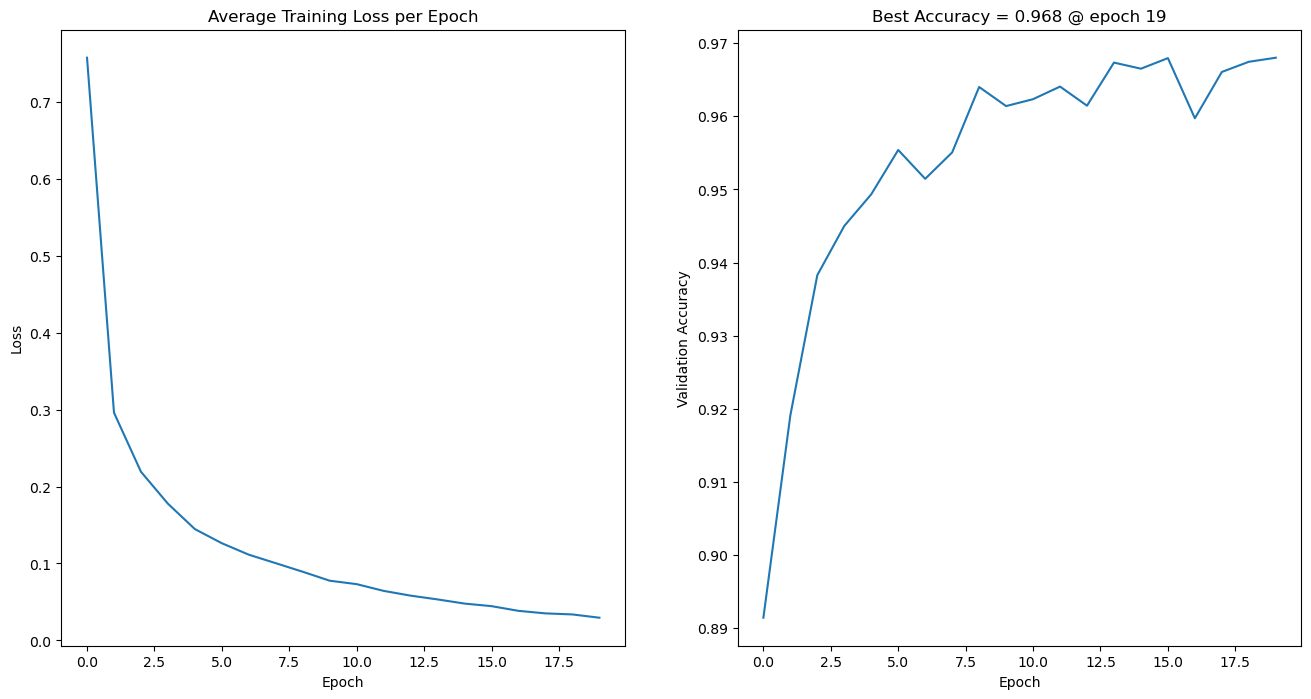

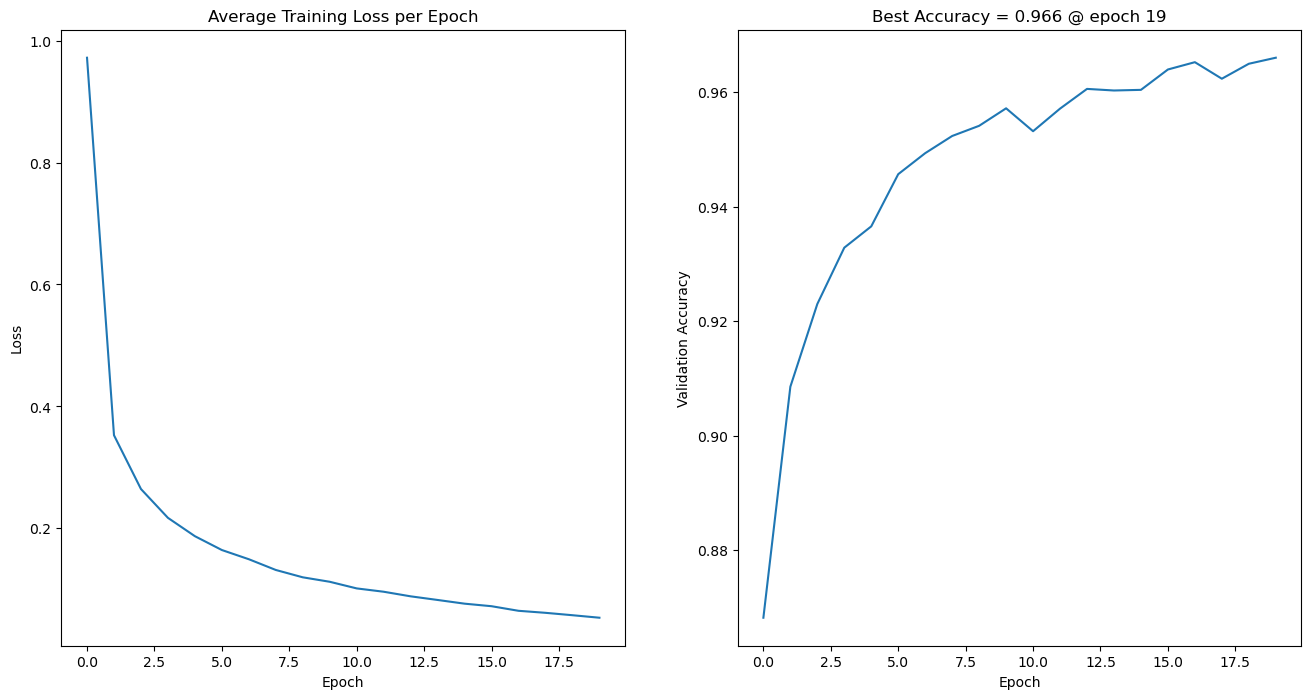

In [10]:

#Seed?
def test_all_models (datasets, models, optimizers, losses, lrs, epochs_set, layers, batch_sizes):
    for dataset in datasets:
        for model in models:
            for opt in optimizers:
                for loss in losses:
                    for lr in lrs:
                        for epochs in epochs_set:
                            for layer_list in layers:
                                for batch_size in batch_sizes:
                                    print(f'Analyzing {dataset}, {model}, {opt}, {loss}, {lr}, {epochs}, {layer_list}, {batch_size}')
                                    test_model(dataset, model, opt, loss, lr, epochs, layer_list, batch_size)                                    


test_all_models(datasets, models, optimizers, losses, lrs, epochs_set, layers, batch_sizes)                             